# A+aron: VCT Mindfreak


## Step 0: Define Target & Load Data
Since we're doing match wins rather than series wins, we have to define what each win or loss looks like. For example, PRX will win is defined by binary 1 and G2 will lose is defined by binary 0.  

And we have to load in all the data to be used in this step.

In [109]:
# Installations
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\noble\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [110]:
import pandas as pd
import numpy as np

# Consider all years
years = [2021, 2022, 2023, 2024, 2025]

# Columns to drop
drop_cols = [
    'Team A Attacker Score',
    'Team A Defender Score',
    'Team A Overtime Score',
    'Team B Attacker Score',
    'Team B Defender Score',
    'Team B Overtime Score'
]

matches = []

for year in years:
    path = f"./vct_{year}/matches/maps_scores.csv"
    df = pd.read_csv(path)
    
    df = df.drop(columns=drop_cols, errors='ignore')
    
    # Compute wins if not already done
    df['team_a_win'] = (df['Team A Score'] > df['Team B Score']).astype(int)
    df['team_b_win'] = (df['Team B Score'] > df['Team A Score']).astype(int)
    
    # Convert to long format
    df_long = pd.concat([
        df.assign(team=df['Team A'],
                  score=df['Team A Score'],
                  opponent=df['Team B'],
                  opponent_score=df['Team B Score'],
                  win=df['team_a_win']),
        df.assign(team=df['Team B'],
                  score=df['Team B Score'],
                  opponent=df['Team A'],
                  opponent_score=df['Team A Score'],
                  win=df['team_b_win'])
    ], ignore_index=True)
    
    # Add year/tournament column if needed
    df_long['Year'] = year
    
    matches.append(df_long)

# Combine all years
all_matches = pd.concat(matches, ignore_index=True)
matches[0].head()


,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team B,Team B Score,Duration,team_a_win,team_b_win,team,score,opponent,opponent_score,win,Year
0,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Haven,Vision Strikers,13,FULL SENSE,5,59:11,1,0,Vision Strikers,13,FULL SENSE,5,1,2021
1,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Breeze,Vision Strikers,13,FULL SENSE,5,44:30,1,0,Vision Strikers,13,FULL SENSE,5,1,2021
2,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Icebox,Team Vikings,13,Crazy Raccoon,9,59:48,1,0,Team Vikings,13,Crazy Raccoon,9,1,2021
3,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Haven,Team Vikings,13,Crazy Raccoon,8,52:48,1,0,Team Vikings,13,Crazy Raccoon,8,1,2021
4,Valorant Champions 2021,Group Stage,Opening (D),FNATIC vs Cloud9,Icebox,FNATIC,13,Cloud9,11,59:50,1,0,FNATIC,13,Cloud9,11,1,2021


In [111]:
all_matches.to_csv("all_matches_2021_2025.csv", index=False)

In [112]:
# View all different files
df1 = pd.read_csv("./vct_2021/players_stats/players_stats.csv") # Player stats: ACS, KDA, FK, FD, headshot %
df3 = pd.read_csv("./vct_2021/matches/draft_phase.csv") # Map picks/bans
df5 = pd.read_csv("./vct_2021/matches/eco_rounds.csv") # Eco rounds
df10 = pd.read_csv("./vct_2021/matches/eco_stats.csv") # Pistol rounds
df7 = pd.read_csv("./vct_2021/matches/maps_scores.csv") # Opponent map matchup & map win rate
df9 = pd.read_csv("./vct_2021/matches/team_mapping.csv") # Logistics; PRX = Paper Rex

# Debatable
df2 = pd.read_csv("./vct_2021/matches/win_loss_methods_count.csv") # Plant/defuse success & closing patterns
df4 = pd.read_csv("./vct_2021/matches/draft_phase.csv") # Perma bans
df6 = pd.read_csv("./vct_2021/players_stats/players_stats.csv") # Clutch factor; none for per game/team. And role adjusted stats
# Roster stability score need to be calculated manually because tables do not provide join/leave dates

# current = df1
# current.head()
# current.info()
# IMPORTS
import matplotlib.pyplot as plt
import pandas as pd
import os

## Step 1: Exploratory Data Analysis (EDA)
Here we must clean data and define what is ACTUALLY useful rather than what we think is useful. This step is made of many points. At the top here, I will keep track of which stats seem to pass the study and move on to be used in the model.  
See this video for univariate and bivariate [here](https://www.youtube.com/watch?v=JG8GRlMjp3c)

### 1.1 Data Cleanup
Make a list of tier 1 teams so you can remove all the irrelavant data before any calculates. **Any blank values (nulls) should also be removed to prevent skewed results.** Duplicates should also be watched out for. China stats are very missing so those need to be cared for so that it doesn't screw the data over. Same with player changes, we want the latest roster.

In [113]:
# Player stats
root_path = "./"
years = range(2021, 2026)

drop_cols = [
    'Rounds Played',
    'Stage',
    'Match Type',
    'Rating',
    'Kill, Assist, Trade, Survive %',
    'Average Damage Per Round',
    'Kills Per Round',
    'Assists Per Round',
    'First Kills Per Round',
    'First Assists Per Round',
    'Maximum Kills in a Single Map',
    'Kills',
    'Assists',
    'Deaths'    
]

all_players = []
for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/players_stats/players_stats.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Compute kda and fk_diff
        df['kda'] = (df['Kills'] + df['Assists']) / df['Deaths'].replace(0, 1)  # avoid division by 0
        df['fk_diff'] = df['First Kills'] - df['First Deaths']
        
        # Drop unnecessary columns
        df = df.drop(columns=drop_cols, errors='ignore')
        
        # Add year column
        df['Year'] = year
        
        all_players.append(df)
    else:
        print(f"File not found: {file_path}")

# Combine all years
player_stats_all = pd.concat(all_players, ignore_index=True)

# Save to CSV at root
player_stats_all.to_csv("player_stats_2021_2025.csv", index=False)

print("Combined player stats saved as 'player_stats_2021_2025.csv'")
#player_stats.describe()
#player_stats.info()

Combined player stats saved as 'player_stats_2021_2025.csv'


In [114]:
# Eco
eco = df5[df5['Type'].str.contains('Eco')]
#eco.head()

all_eco = []

for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/matches/eco_rounds.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Drop rows with missing Loadout Value or Outcome
        df = df.dropna(subset=['Loadout Value', 'Outcome'])
        df['Loadout Value'] = (
            df['Loadout Value']
            .astype(str)                        # ensure it's string
            .str.replace('k', '', regex=False)   # remove 'k'
            .astype(float) * 1000                # convert to integer
        )
        
        # Filter only Eco rounds
        eco = df[df['Type'].str.contains('Eco', na=False)].copy()
        # Compute round_win column
        eco['round_win'] = (eco['Outcome'] == 'Win').astype(int)
        
        # Add year column
        eco['Year'] = year
        
        all_eco.append(eco)
    else:
        print(f"File not found: {file_path}")

# Combine all years
eco_all = pd.concat(all_eco, ignore_index=True)

# Save to CSV at root
eco_all.to_csv("eco_rounds_2021_2025.csv", index=False)

print("Combined eco rounds saved as 'eco_rounds_2021_2025.csv'")

Combined eco rounds saved as 'eco_rounds_2021_2025.csv'


In [115]:
# ==========PISTOL ROUNDS (ALL YEARS)==========
all_pistol = []

for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/matches/eco_stats.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Remove aggregated rows like "All Maps" if needed
        df = df[df['Map'] != 'All Maps'].copy()
        
        # Keep only pistol rounds
        df = df[df['Type'] == 'Pistol Won'].copy()
        
        # Drop only rows missing essential info
        df = df.dropna(subset=['Team', 'Map', 'Won'])
        
        # Ensure Won is numeric
        df['Won'] = pd.to_numeric(df['Won'], errors='coerce').fillna(0)
        
        # Add Year column
        df['Year'] = year
        
        all_pistol.append(df)
    else:
        print(f"File not found: {file_path}")

# Combine all years
pistol_all = pd.concat(all_pistol, ignore_index=True)
pistol = pistol_all.copy()

# Save to CSV
pistol_all.to_csv("pistol_rounds_2021_2025.csv", index=False)

print(f"Combined pistol rounds saved as 'pistol_rounds_2021_2025.csv', total rows: {len(pistol_all)}")


Combined pistol rounds saved as 'pistol_rounds_2021_2025.csv', total rows: 40866


In [116]:
# Picks Bans
all_pickban = []

for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/matches/draft_phase.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Drop rows with missing Team, Action, or Map
        df = df.dropna(subset=['Team', 'Action', 'Map'])
        
        # Reset index
        df = df.reset_index(drop=True)
        
        # Strip whitespace and lowercase
        df['Action'] = df['Action'].str.strip().str.lower()
        df['Team'] = df['Team'].str.strip()
        df['Map'] = df['Map'].str.strip()
        
        # Add year column
        df['Year'] = year
        
        all_pickban.append(df)
    else:
        print(f"File not found: {file_path}")

# Combine all years
pickban_all = pd.concat(all_pickban, ignore_index=True)

# Save to CSV at root
pickban_all.to_csv("pickban_2021_2025.csv", index=False)

print("Combined pick/ban data saved as 'pickban_2021_2025.csv'")


Combined pick/ban data saved as 'pickban_2021_2025.csv'


### 1.2 Univariate EDA
Univariate is used to determine the first pass of some of these values. Here we ask, "Does this feature matter at all?" and "Is it anyhow related to winning?". This is the important first step as you can see ever so slightly the possible relationship between win and factor.

**Univariate Analysis Approach:**
- **Correct methodology**: We aggregate features to team level (per tournament) and compare against team win rates
- **Plots**: Scatter plots show the relationship between feature values and win rates
- **Bins**: Quartile binning helps identify non-linear relationships and shows clear patterns
- **Both methods are complementary**: Plots show distribution, bins show discrete patterns

**Results Summary (2021-2025):**  
**FK-FD (fk_diff)** - Passes univariate EDA, plots roughly show some correlation  
**Headshot %** - Failed univariate EDA as increase of headshot % did not anyhow increase the win rate of the team, this value will not be studied or used  
**ACS, KDA** - Passes univariate EDA but is very similar hence we can pick one, drop the other  
**Eco Rounds** - Passes univariate EDA, specifically round win rate and avg loadout but we have to remember it seems like how they manage money is more important seeing that loadout is the source of pattern  
**Pistol Rounds** - Passes univariate EDA and we can see if you win both pistols, the win rate skyrockets as compared to not winning any pistols  
**Map win rate** - Passes univariate EDA  
**Opponent map matchup** - Sample size small so there isn't a lot to see but seems ok correlation  
**Map picks/bans** - Poor major predictor but can be used with other factors  

In [117]:
# Plots to try
# Histogram
# plt.hist(df1['fk_diff'], bins=15)
# plt.xlabel('First Kill Differential')
# plt.ylabel('Count')
# plt.title('Distribution of FK Differential')
# plt.show()

# Boxplot
# plt.boxplot(df1['fk_diff'], vert=False)
# plt.xlabel('First Kill Differential')
# plt.title('FK Differential Boxplot')
# plt.show()

# Scatterplot
# df1.plot.scatter(x='fk_diff', y='kda')

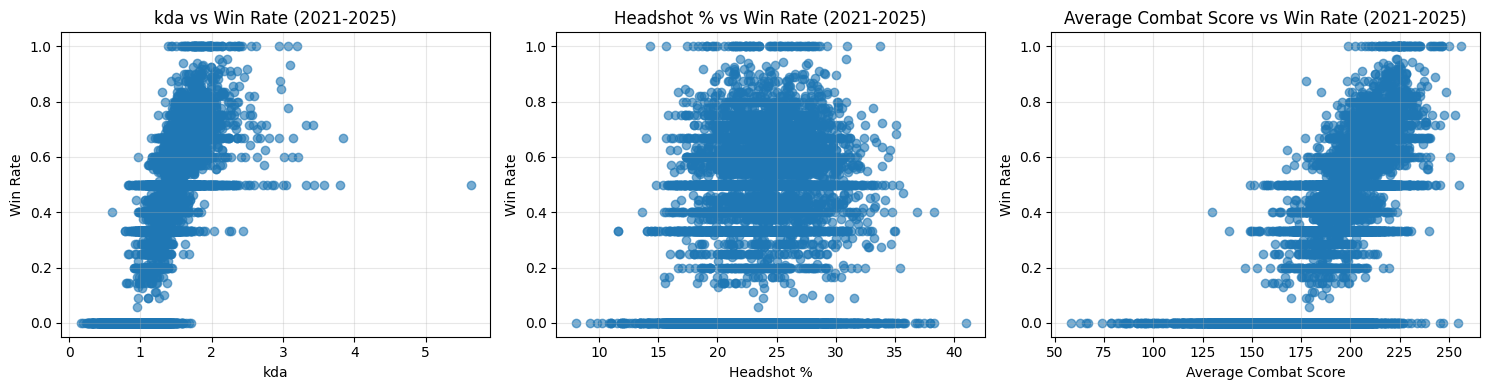


=== BIN ANALYSIS: Player Stats ===

kda Bins -> Average Win Rate:
          kda_bin  avg_win_rate  count
0  (0.163, 1.045]      0.025824   2053
1  (1.045, 1.308]      0.247277   2053
2  (1.308, 1.541]      0.475442   2052
3  (1.541, 5.629]      0.645778   2053

Headshot % Bins -> Average Win Rate:
     Headshot %_bin  avg_win_rate  count
0   (7.999, 20.895]      0.265329   2037
1  (20.895, 23.398]      0.360232   2035
2  (23.398, 25.848]      0.382506   2035
3    (25.848, 41.0]      0.384066   2036

Average Combat Score Bins -> Average Win Rate:
  Average Combat Score_bin  avg_win_rate  count
0          (58.142, 179.4]      0.058526   2055
1         (179.4, 196.286]      0.281244   2051
2       (196.286, 208.229]      0.451394   2051
3       (208.229, 255.944]      0.603583   2053


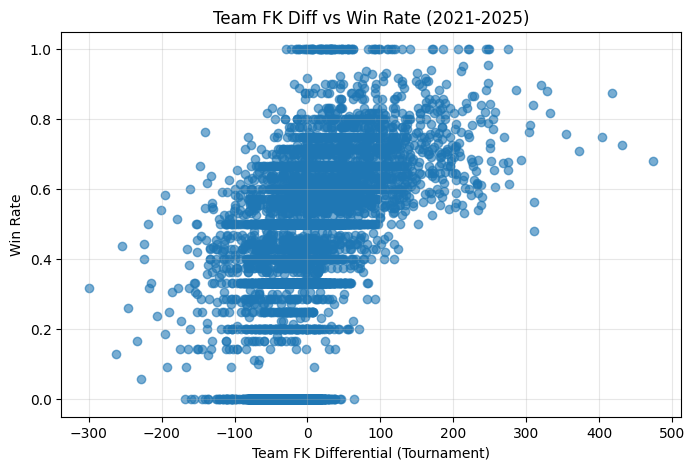


=== FK Differential Bins -> Average Win Rate ===
         fk_diff_bin  avg_win_rate  count
0  (-299.001, -31.5]      0.231954   2053
1      (-31.5, -8.0]      0.209959   2162
2       (-8.0, 20.0]      0.348651   1999
3      (20.0, 474.0]      0.618418   1997


In [118]:
# ==========PLAYER STATS (2021-2025)==========
# Univariate EDA: Check if player stats correlate with team win rates
# Using all years (2021-2025) for comprehensive analysis

import matplotlib.pyplot as plt

# Make sure 'Headshot %' is numeric (convert percentage string to float)
player_stats_all['Headshot %'] = player_stats_all['Headshot %'].str.rstrip('%').astype(float)

# Metrics to study: KDA, Headshot %, and ACS
metrics = ['kda', 'Headshot %', 'Average Combat Score']

# --- Aggregate player metrics to team level (all years) ---
# Group by Tournament and Teams to get average stats per team per tournament
team_stats = player_stats_all.groupby(
    ['Tournament', 'Teams'],
    as_index=False
).agg({
    'kda': 'mean',
    'Headshot %': 'mean',
    'Average Combat Score': 'mean'
})

# --- Compute team win rates using ALL matches (2021-2025) ---
# Changed from matches[0] to all_matches to include all years
team_wins = all_matches.groupby(
    ['Tournament', 'team'],
    as_index=False
)['win'].mean()

# Rename for consistent merge (standardize column name)
team_wins.rename(columns={'team': 'Teams'}, inplace=True)

# --- Merge metrics with win rate ---
team_metrics = team_stats.merge(
    team_wins,
    on=['Tournament', 'Teams'],
    how='inner'
)

# --- PLOTS: Scatter plots for metrics vs win rate ---
n = len(metrics)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
for i, m in enumerate(metrics):
    ax = axes[i]
    ax.scatter(team_metrics[m], team_metrics['win'], alpha=0.6)
    ax.set_xlabel(m)
    ax.set_ylabel('Win Rate')
    ax.set_title(f'{m} vs Win Rate (2021-2025)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- BINS: Bin analysis for each metric ---
print("\n=== BIN ANALYSIS: Player Stats ===")
for m in metrics:
    # Create 4 quartile bins
    team_metrics[f'{m}_bin'] = pd.qcut(team_metrics[m], 4, duplicates='drop')
    # Compute average win rate per bin
    bin_summary = team_metrics.groupby(f'{m}_bin', observed=True).agg(
        avg_win_rate=('win', 'mean'),
        count=('win', 'count')
    ).reset_index()
    print(f"\n{m} Bins -> Average Win Rate:")
    print(bin_summary)

# --- First Kill Differential Analysis ---
# Aggregate First Kills / First Deaths per player
player_fk = player_stats_all.groupby(
    ['Tournament', 'Teams', 'Player'],
    as_index=False
).agg({
    'First Kills': 'sum',
    'First Deaths': 'sum'
})

# Calculate FK differential (First Kills - First Deaths)
player_fk['fk_diff'] = player_fk['First Kills'] - player_fk['First Deaths']

# Aggregate to team level (sum of all players' FK differentials)
team_fk = player_fk.groupby(
    ['Tournament', 'Teams'],
    as_index=False
)['fk_diff'].sum()

# Merge with win rates
team_fk_merged = team_fk.merge(
    team_wins,
    on=['Tournament', 'Teams'],
    how='inner'
)

# --- PLOT: FK diff vs Win Rate ---
plt.figure(figsize=(8, 5))
plt.scatter(team_fk_merged['fk_diff'], team_fk_merged['win'], alpha=0.6)
plt.xlabel('Team FK Differential (Tournament)')
plt.ylabel('Win Rate')
plt.title('Team FK Diff vs Win Rate (2021-2025)')
plt.grid(True, alpha=0.3)
plt.show()

# --- BINS: FK diff bin analysis ---
team_fk_merged['fk_diff_bin'] = pd.qcut(team_fk_merged['fk_diff'], 4, duplicates='drop')
fk_bin_summary = team_fk_merged.groupby('fk_diff_bin', observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()
print("\n=== FK Differential Bins -> Average Win Rate ===")
print(fk_bin_summary)


=== ECO ROUNDS: Loadout Value Bins -> Average Round Win Rate (2021-2025) ===
        loadout_bin  avg_round_win_rate  count
0  (-0.001, 3100.0]            0.218497  10038
1  (3100.0, 3450.0]            0.347011  10033
2  (3450.0, 3750.0]            0.559989  10864
3  (3750.0, 4600.0]            0.623059   8967


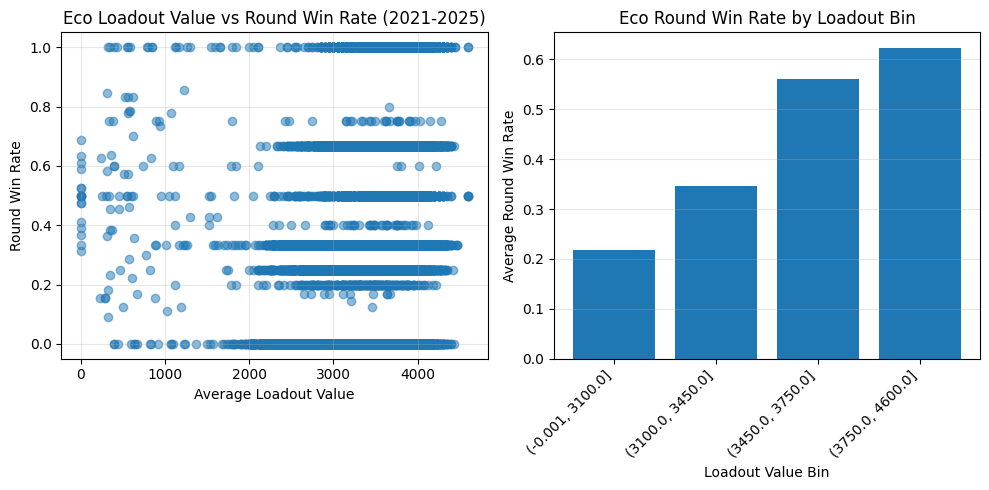


=== ECO ROUNDS: Round Win Rate Bins -> Match Win Proxy Rate (2021-2025) ===
        round_bin  match_win_rate  count
0  (-0.001, 0.25]        0.000000  11903
1   (0.25, 0.333]        0.000000  13738
2  (0.333, 0.667]        0.528255   5238
3    (0.667, 1.0]        1.000000   9023


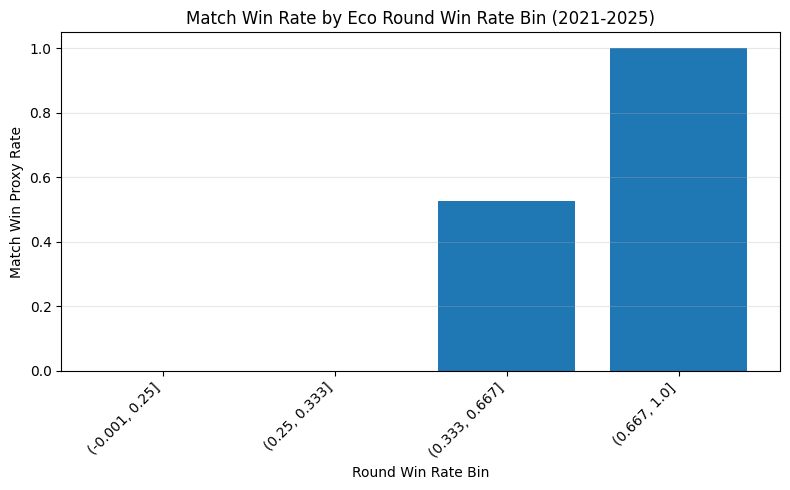

In [119]:
# ==========ECO ROUNDS (2021-2025)==========
# Univariate EDA: Analyze eco round performance (loadout value and round win rate)
# Using all years (2021-2025) - changed from eco to eco_all

import matplotlib.pyplot as plt

# Aggregation columns for grouping
agg_cols = ['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'Team']

# Aggregate eco rounds per team per match (using eco_all for all years)
eco_team = eco_all.groupby(agg_cols).agg(
    avg_loadout=('Loadout Value', 'mean'),
    round_wins=('round_win', 'sum'),      # sum of wins
    total_rounds=('round_win', 'count')
).reset_index()

# Calculate round win rate (wins / total rounds)
eco_team['round_win_rate'] = eco_team['round_wins'] / eco_team['total_rounds']
# Proxy for match win: if team wins >50% of eco rounds, they likely won the match
eco_team['match_win_proxy'] = (eco_team['round_win_rate'] > 0.5).astype(int)

# --- BINS: Loadout value analysis ---
# Bin avg_loadout into 4 quartiles
eco_team['loadout_bin'] = pd.qcut(eco_team['avg_loadout'], 4, duplicates='drop')

# Compute average round win rate per bin
loadout_bin_summary = eco_team.groupby('loadout_bin', observed=True).agg(
    avg_round_win_rate=('round_win_rate', 'mean'),
    count=('round_win_rate', 'count')
).reset_index()

print("=== ECO ROUNDS: Loadout Value Bins -> Average Round Win Rate (2021-2025) ===")
print(loadout_bin_summary)

# --- PLOTS: Loadout value vs round win rate ---
plt.figure(figsize=(10, 5))

# Plot 1: Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(eco_team['avg_loadout'], eco_team['round_win_rate'], alpha=0.5)
plt.xlabel('Average Loadout Value')
plt.ylabel('Round Win Rate')
plt.title('Eco Loadout Value vs Round Win Rate (2021-2025)')
plt.grid(True, alpha=0.3)

# Plot 2: Bar chart of bins
plt.subplot(1, 2, 2)
bin_labels = [str(interval) for interval in loadout_bin_summary['loadout_bin']]
plt.bar(range(len(loadout_bin_summary)), loadout_bin_summary['avg_round_win_rate'])
plt.xlabel('Loadout Value Bin')
plt.ylabel('Average Round Win Rate')
plt.title('Eco Round Win Rate by Loadout Bin')
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- BINS: Round win rate analysis ---
# Bin round win rate into quartiles
eco_team['round_bin'] = pd.qcut(eco_team['round_win_rate'], 4, duplicates='drop')

# Compute match win proxy rate per round win rate bin
round_bin_summary = eco_team.groupby('round_bin', observed=True).agg(
    match_win_rate=('match_win_proxy', 'mean'),
    count=('match_win_proxy', 'count')
).reset_index()

print("\n=== ECO ROUNDS: Round Win Rate Bins -> Match Win Proxy Rate (2021-2025) ===")
print(round_bin_summary)

# --- PLOT: Round win rate vs match win proxy ---
plt.figure(figsize=(8, 5))
bin_labels_round = [str(interval) for interval in round_bin_summary['round_bin']]
plt.bar(range(len(round_bin_summary)), round_bin_summary['match_win_rate'])
plt.xlabel('Round Win Rate Bin')
plt.ylabel('Match Win Proxy Rate')
plt.title('Match Win Rate by Eco Round Win Rate Bin (2021-2025)')
plt.xticks(range(len(bin_labels_round)), bin_labels_round, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


=== PISTOL ROUNDS: Pistol Wins Bins -> Map Win Rate (2021-2025) ===
   pistol_wins_bin  map_win_rate  num_maps
0                0      0.374804     23012
1                1      0.499974     19475
2                2      0.764030     10709


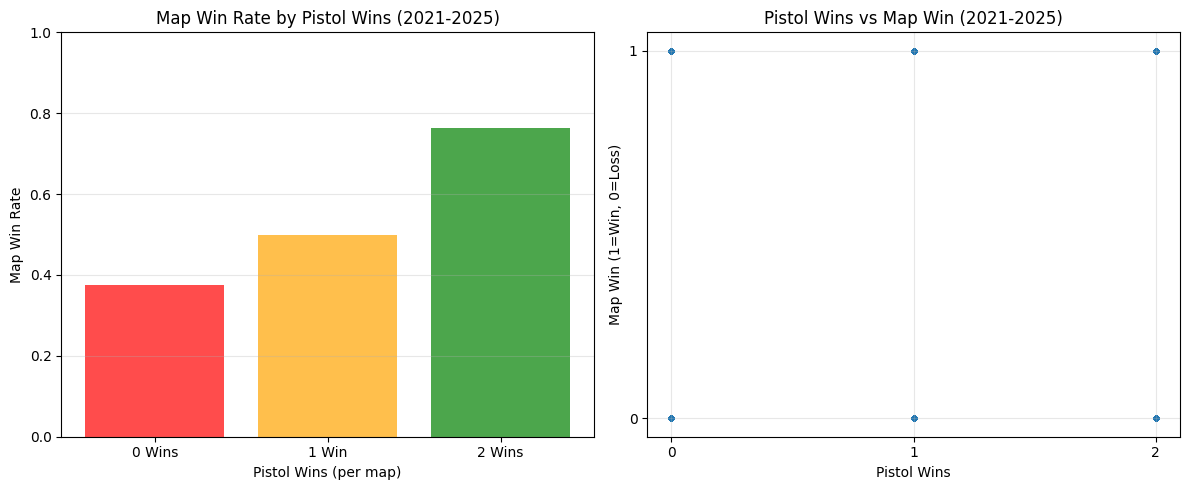

In [120]:
# ==========PISTOL ROUNDS (2021-2025)==========
# Univariate EDA: Analyze pistol round wins and their impact on map wins
# Using all years (2021-2025) - changed from matches[0] to all_matches and pistol to pistol_all

import matplotlib.pyplot as plt

# Aggregation columns for grouping
agg_cols = ['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'Team']

# Aggregate per team per match (using pistol_all for all years)
pistol_team_map = pistol_all.groupby(agg_cols).agg(
    pistol_wins=('Won', 'sum'),
).reset_index()

# Cap pistol wins at 2 per map per match (max 2 pistol rounds per map)
pistol_team_map['pistol_wins'] = pistol_team_map['pistol_wins'].clip(upper=2)

# Compute win rate (0, 0.5, 1, depending on 0/1/2 wins)
pistol_team_map['pistol_win_rate'] = pistol_team_map['pistol_wins'] / 2

# Rename team column to match matches table (standardize naming)
pistol_team_map = pistol_team_map.rename(columns={'Team': 'team'})

# Merge with ALL matches table (map-level) - changed from matches[0] to all_matches
pistol_merged = all_matches.merge(
    pistol_team_map,
    on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
    how='left'
)

# Fill missing values (teams with no pistol data get 0 wins)
pistol_merged[['pistol_wins', 'pistol_win_rate']] = pistol_merged[['pistol_wins', 'pistol_win_rate']].fillna(0)

# Bin for analysis (0, 1, 2 pistol wins)
pistol_merged['pistol_wins_bin'] = pistol_merged['pistol_wins'].astype(int)

# --- BINS: Compute map win rate per pistol bin ---
pistol_bin_summary = pistol_merged.groupby('pistol_wins_bin', observed=True).agg(
    map_win_rate=('win', 'mean'),
    num_maps=('win', 'count')
).reset_index().sort_values('pistol_wins_bin')

print("=== PISTOL ROUNDS: Pistol Wins Bins -> Map Win Rate (2021-2025) ===")
print(pistol_bin_summary)

# --- PLOTS: Visualize pistol wins impact ---
plt.figure(figsize=(12, 5))

# Plot 1: Bar chart of win rates by pistol wins
plt.subplot(1, 2, 1)
plt.bar(pistol_bin_summary['pistol_wins_bin'], pistol_bin_summary['map_win_rate'], 
        color=['red', 'orange', 'green'], alpha=0.7)
plt.xlabel('Pistol Wins (per map)')
plt.ylabel('Map Win Rate')
plt.title('Map Win Rate by Pistol Wins (2021-2025)')
plt.xticks([0, 1, 2], ['0 Wins', '1 Win', '2 Wins'])
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Scatter plot with sample size
plt.subplot(1, 2, 2)
plt.scatter(pistol_merged['pistol_wins'], pistol_merged['win'], alpha=0.1, s=10)
plt.xlabel('Pistol Wins')
plt.ylabel('Map Win (1=Win, 0=Loss)')
plt.title('Pistol Wins vs Map Win (2021-2025)')
plt.xticks([0, 1, 2])
plt.yticks([0, 1])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== MAP WIN RATE: Correlation (2021-2025) ===
Correlation between historical map win rate and actual wins: 0.534

=== MAP WIN RATE: Historical Win Rate Bins -> Actual Win Rate (2021-2025) ===
  hist_winrate_bin  actual_win_rate  count
0  (-0.001, 0.375]         0.119844  13551
1   (0.375, 0.545]         0.482777  13064
2   (0.545, 0.667]         0.614635  14267
3     (0.667, 1.0]         0.804447  12232


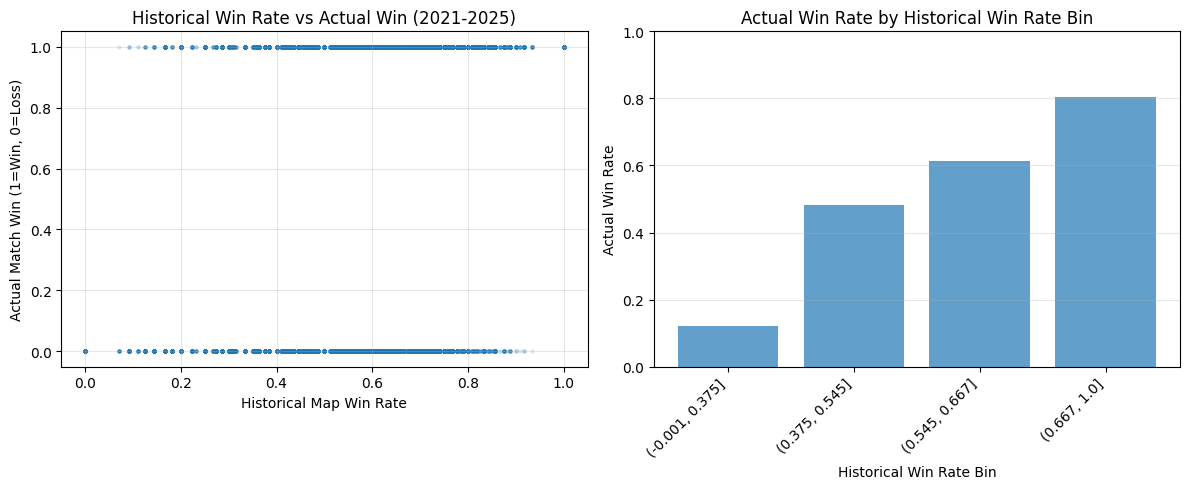

In [121]:
# ==========MAP WIN RATE (2021-2025)==========
# Univariate EDA: Analyze historical map win rate as a predictor
# Using all years (2021-2025) - changed from matches[1] to all_matches

import matplotlib.pyplot as plt

# 1️⃣ Compute historical win rate per Team × Map (using all matches)
# This calculates each team's win rate on each map across all tournaments
team_map_winrate = all_matches.groupby(['team', 'Map'], observed=True).agg(
    historical_win_rate=('win', 'mean'),
    num_matches=('win', 'count')
).reset_index()

# 2️⃣ Merge historical win rate back to each match
matches_hist = all_matches.merge(
    team_map_winrate,
    on=['team', 'Map'],
    how='left'
)

# 3️⃣ Compute correlation between historical win rate and actual match outcomes
corr = matches_hist['win'].corr(matches_hist['historical_win_rate'])
print(f"=== MAP WIN RATE: Correlation (2021-2025) ===")
print(f"Correlation between historical map win rate and actual wins: {corr:.3f}")

# --- BINS: Bin historical win rate and check actual win rate ---
# Create bins for historical win rate
matches_hist['hist_winrate_bin'] = pd.qcut(matches_hist['historical_win_rate'], 4, duplicates='drop')

# Compute actual win rate per bin
winrate_bin_summary = matches_hist.groupby('hist_winrate_bin', observed=True).agg(
    actual_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("\n=== MAP WIN RATE: Historical Win Rate Bins -> Actual Win Rate (2021-2025) ===")
print(winrate_bin_summary)

# --- PLOTS: Visualize historical win rate relationship ---
plt.figure(figsize=(12, 5))

# Plot 1: Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(matches_hist['historical_win_rate'], matches_hist['win'], alpha=0.1, s=5)
plt.xlabel('Historical Map Win Rate')
plt.ylabel('Actual Match Win (1=Win, 0=Loss)')
plt.title('Historical Win Rate vs Actual Win (2021-2025)')
plt.grid(True, alpha=0.3)

# Plot 2: Bar chart of bins
plt.subplot(1, 2, 2)
bin_labels = [str(interval) for interval in winrate_bin_summary['hist_winrate_bin']]
plt.bar(range(len(winrate_bin_summary)), winrate_bin_summary['actual_win_rate'], alpha=0.7)
plt.xlabel('Historical Win Rate Bin')
plt.ylabel('Actual Win Rate')
plt.title('Actual Win Rate by Historical Win Rate Bin')
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


=== OPPONENT MATCHUP: Top 10 Matchups by Win Rate (2021-2025) ===
                    team        opponent       Map  matches_played  wins  \
0      #1 Victory Royale        Karasuno      Bind               1     1   
25231  Nanashi no Gonbee  Sengoku Gaming    Ascent               1     1   
25228  Nanashi no Gonbee           Noizy    Ascent               1     1   
25227  Nanashi no Gonbee      No Country     Split               1     1   
25226  Nanashi no Gonbee   Nenkoujoretsu    Ascent               1     1   
25222  Nanashi no Gonbee   Glory be Diva    Ascent               1     1   
25218  Nanashi no Gonbee    FIRST Gaming    Ascent               1     1   
25215  Nanashi no Gonbee    Atlas Gaming      Bind               1     1   
25214  Nanashi no Gonbee    Atlas Gaming    Ascent               1     1   
25206   Nameless Esports    Able Esports  Fracture               1     1   

       win_rate  
0           1.0  
25231       1.0  
25228       1.0  
25227       1.0  
25226  

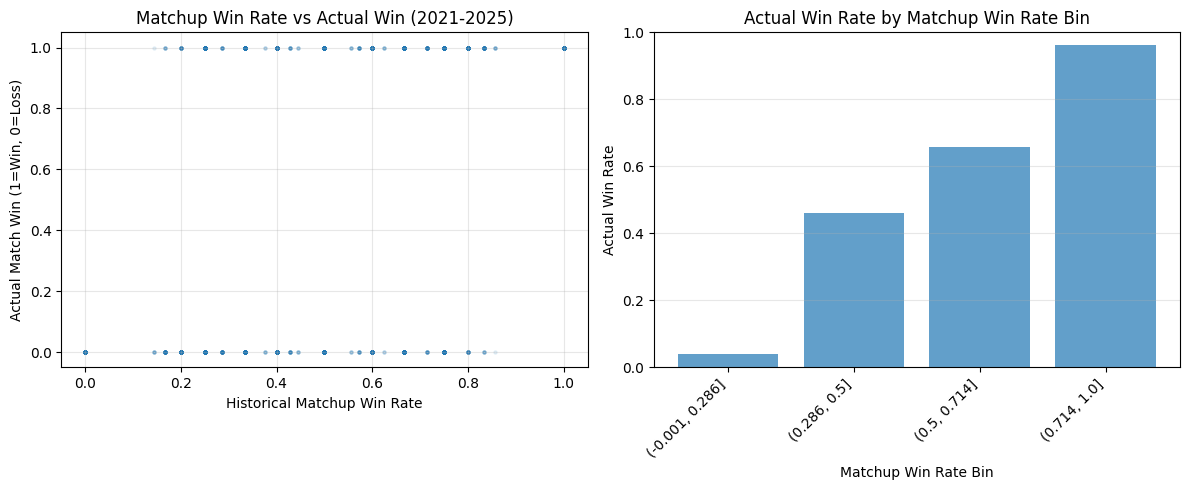

In [122]:
# ==========OPPONENT MAP MATCHUP (2021-2025)==========
# Univariate EDA: Analyze head-to-head matchup win rates
# Using all years (2021-2025) - changed from matches[0] to all_matches

import matplotlib.pyplot as plt

# 1️⃣ Compute historical matchup stats (team vs opponent on specific map)
matchup_stats = all_matches.groupby(['team', 'opponent', 'Map'], observed=True).agg(
    matches_played=('win', 'count'),
    wins=('win', 'sum'),
    win_rate=('win', 'mean')
).reset_index()

# Show top matchups by win rate
print("=== OPPONENT MATCHUP: Top 10 Matchups by Win Rate (2021-2025) ===")
print(matchup_stats.sort_values(['win_rate'], ascending=False).head(10))

# 2️⃣ Merge historical matchup win rate back to each match
matchup_merged = all_matches.merge(
    matchup_stats,
    on=['team', 'opponent', 'Map'],
    how='left',
    suffixes=('', '_hist')
)

# 3️⃣ Compute correlation
corr_matchup = matchup_merged['win'].corr(matchup_merged['win_rate'])
print(f"\n=== OPPONENT MATCHUP: Correlation (2021-2025) ===")
print(f"Correlation team vs opponent map matchup: {corr_matchup:.3f}")

# --- BINS: Bin matchup win rate and check actual win rate ---
# Create bins for matchup win rate (only for matchups with sufficient data)
matchup_merged_filtered = matchup_merged[matchup_merged['matches_played'] >= 2].copy()
matchup_merged_filtered['matchup_bin'] = pd.qcut(matchup_merged_filtered['win_rate'], 4, duplicates='drop')

# Compute actual win rate per bin
matchup_bin_summary = matchup_merged_filtered.groupby('matchup_bin', observed=True).agg(
    actual_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("\n=== OPPONENT MATCHUP: Matchup Win Rate Bins -> Actual Win Rate (2021-2025) ===")
print(matchup_bin_summary)

# --- PLOTS: Visualize matchup relationship ---
plt.figure(figsize=(12, 5))

# Plot 1: Scatter plot (filtered for better visualization)
plt.subplot(1, 2, 1)
plt.scatter(matchup_merged_filtered['win_rate'], matchup_merged_filtered['win'], alpha=0.1, s=5)
plt.xlabel('Historical Matchup Win Rate')
plt.ylabel('Actual Match Win (1=Win, 0=Loss)')
plt.title('Matchup Win Rate vs Actual Win (2021-2025)')
plt.grid(True, alpha=0.3)

# Plot 2: Bar chart of bins
plt.subplot(1, 2, 2)
bin_labels = [str(interval) for interval in matchup_bin_summary['matchup_bin']]
plt.bar(range(len(matchup_bin_summary)), matchup_bin_summary['actual_win_rate'], alpha=0.7)
plt.xlabel('Matchup Win Rate Bin')
plt.ylabel('Actual Win Rate')
plt.title('Actual Win Rate by Matchup Win Rate Bin')
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



=== MAP PICKS/BANS: Sample Data (2021-2025) ===
          Team       Map  pick_fraction  ban_fraction  pref_score  win_rate
0  100 Thieves     Abyss       0.003125      0.009375   -0.006250  0.000000
1  100 Thieves    Ascent       0.062500      0.071875   -0.009375  0.614035
2  100 Thieves      Bind       0.084375      0.081250    0.003125  0.541667
3  100 Thieves    Breeze       0.034375      0.037500   -0.003125  0.633333
4  100 Thieves   Corrode       0.000000      0.003125   -0.003125  1.000000
5  100 Thieves  Fracture       0.031250      0.018750    0.012500  0.590909
6  100 Thieves     Haven       0.065625      0.059375    0.006250  0.576271
7  100 Thieves    Icebox       0.059375      0.068750   -0.009375  0.625000
8  100 Thieves     Lotus       0.006250      0.100000   -0.093750  0.357143
9  100 Thieves     Pearl       0.003125      0.043750   -0.040625  0.444444

=== MAP PICKS/BANS: Preference Score Bins -> Win Rate (2021-2025) ===
            pref_bin  avg_win_rate  count
0  

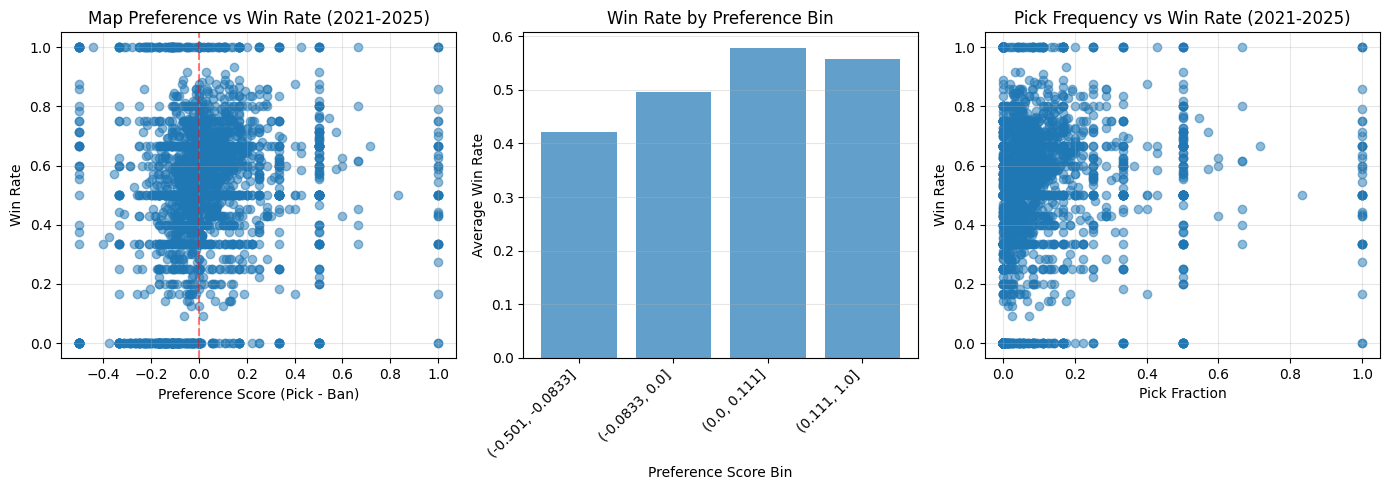

In [123]:
# ==========MAP PICKS AND BANS (2021-2025)==========
# Univariate EDA: Analyze map pick/ban preferences and their relationship to win rates
# Using all years (2021-2025) - changed from matches[0] to all_matches

import matplotlib.pyplot as plt

# Count picks and bans per team per map
pickban_counts = (
    pickban_all
    .groupby(['Team', 'Action', 'Map'], observed=True)
    .size()
    .reset_index(name='count')
)

# 1️⃣ Compute team × map win rate (using all matches)
team_map_winrate = all_matches.groupby(['team', 'Map'], observed=True).agg(
    matches_played=('win', 'count'),
    wins=('win', 'sum'),
    win_rate=('win', 'mean')
).reset_index()

# 2️⃣ Merge picks/bans with win rate
pickban_merged = pickban_counts.merge(
    team_map_winrate,
    left_on=['Team', 'Map'],
    right_on=['team', 'Map'],
    how='left'
)

# 3️⃣ Compute fractions of total actions per team
# Total number of picks + bans per team
team_total_actions = pickban_merged.groupby('Team')['count'].sum().reset_index().rename(columns={'count': 'total_actions'})

pickban_merged = pickban_merged.merge(team_total_actions, on='Team', how='left')

# Fraction of actions per map (how often team picks/bans this map relative to all their actions)
pickban_merged['action_fraction'] = pickban_merged['count'] / pickban_merged['total_actions']

# 4️⃣ Pivot picks and bans into separate columns
pick_fraction = pickban_merged[pickban_merged['Action'] == 'pick'][['Team', 'Map', 'action_fraction']].rename(columns={'action_fraction': 'pick_fraction'})
ban_fraction = pickban_merged[pickban_merged['Action'] == 'ban'][['Team', 'Map', 'action_fraction']].rename(columns={'action_fraction': 'ban_fraction'})

team_pref = pick_fraction.merge(ban_fraction, on=['Team', 'Map'], how='outer').fillna(0)

# 5️⃣ Compute preference score (pick_fraction - ban_fraction)
# Positive = prefer to pick, Negative = prefer to ban
team_pref['pref_score'] = team_pref['pick_fraction'] - team_pref['ban_fraction']

# 6️⃣ Merge actual win rate
team_pref = team_pref.merge(
    team_map_winrate[['team', 'Map', 'win_rate']],
    left_on=['Team', 'Map'],
    right_on=['team', 'Map'],
    how='left'
)

# Keep relevant columns
team_pref = team_pref[['Team', 'Map', 'pick_fraction', 'ban_fraction', 'pref_score', 'win_rate']].dropna()

print("=== MAP PICKS/BANS: Sample Data (2021-2025) ===")
print(team_pref.head(10))

# --- BINS: Bin preference score and check win rate ---
team_pref['pref_bin'] = pd.qcut(team_pref['pref_score'], 4, duplicates='drop')

pref_bin_summary = team_pref.groupby('pref_bin', observed=True).agg(
    avg_win_rate=('win_rate', 'mean'),
    count=('win_rate', 'count')
).reset_index()

print("\n=== MAP PICKS/BANS: Preference Score Bins -> Win Rate (2021-2025) ===")
print(pref_bin_summary)

# --- PLOTS: Visualize pick/ban preferences vs win rate ---
plt.figure(figsize=(14, 5))

# Plot 1: Scatter plot - preference score vs win rate
plt.subplot(1, 3, 1)
plt.scatter(team_pref['pref_score'], team_pref['win_rate'], alpha=0.5)
plt.xlabel('Preference Score (Pick - Ban)')
plt.ylabel('Win Rate')
plt.title('Map Preference vs Win Rate (2021-2025)')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot 2: Bar chart of bins
plt.subplot(1, 3, 2)
bin_labels = [str(interval) for interval in pref_bin_summary['pref_bin']]
plt.bar(range(len(pref_bin_summary)), pref_bin_summary['avg_win_rate'], alpha=0.7)
plt.xlabel('Preference Score Bin')
plt.ylabel('Average Win Rate')
plt.title('Win Rate by Preference Bin')
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Plot 3: Pick fraction vs win rate
plt.subplot(1, 3, 3)
plt.scatter(team_pref['pick_fraction'], team_pref['win_rate'], alpha=0.5)
plt.xlabel('Pick Fraction')
plt.ylabel('Win Rate')
plt.title('Pick Frequency vs Win Rate (2021-2025)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3 Correlation Pruning EDA
We want to get rid of redundant factors. KDA and ACS are often used a lot but never together. They are somewhat related values and have shown to have a similar relationship with win rate. I don't see a need to have to calculate them together so ACS is pruned

In [124]:
# ==========KDA VS ACS CORRELATION (2021-2025)==========
# Correlation pruning: Remove redundant features that are highly correlated
# Using team_metrics from Player Stats section (updated variable name)

corr_matrix = team_metrics[['kda', 'Average Combat Score']].corr()
print("=== CORRELATION PRUNING: KDA vs ACS (2021-2025) ===")
print("Correlation matrix:\n", corr_matrix)

threshold = 0.8  # Threshold for high correlation
if abs(corr_matrix.loc['kda', 'Average Combat Score']) > threshold:
    print(f"\nKDA and ACS are highly correlated ({corr_matrix.loc['kda', 'Average Combat Score']:.2f}), pruning ACS")
    team_metrics = team_metrics.drop(columns=['Average Combat Score'])
    metrics = [m for m in metrics if m != 'Average Combat Score']  # update metrics list for plots
else:
    print(f"\nKDA and ACS correlation is moderate ({corr_matrix.loc['kda', 'Average Combat Score']:.2f}), keep both")


=== CORRELATION PRUNING: KDA vs ACS (2021-2025) ===
Correlation matrix:
                            kda  Average Combat Score
kda                   1.000000              0.858532
Average Combat Score  0.858532              1.000000

KDA and ACS are highly correlated (0.86), pruning ACS


### 1.4 Bivariate & Grouped EDA
Trying to see how two things interact together. This one is not the same as univariate (obviously). My take on this is to make certain values stronger than they were before especially factors that don't really show much relationship by themselves. We want to see if we can classify better than seeing one factor.  

In [137]:
# ==========BIVARIATE EDA: KDA VS FK DIFFERENTIAL (2021-2025)==========
# Bivariate analysis: How do KDA and FK differential interact to predict win rate?
# Using all years (2021-2025) - updated variable names

import matplotlib.pyplot as plt
import numpy as np

# Get KDA and win rate data
team_kda = team_metrics[['Tournament', 'Teams', 'kda', 'win']]
# Get FK differential data (from Player Stats section)
team_fk_data = team_fk_merged[['Tournament', 'Teams', 'fk_diff']]

# Merge KDA and FK data
team_kda_fk = team_kda.merge(
    team_fk_data,
    on=['Tournament', 'Teams'],
    how='inner'
)

# --- PLOTS: Bivariate visualization ---
# plt.figure(figsize=(12, 5))

# # Plot 1: Scatter plot colored by win rate
# plt.subplot(1, 2, 1)
# scatter = plt.scatter(
#     team_kda_fk['kda'],
#     team_kda_fk['fk_diff'],
#     c=team_kda_fk['win'],
#     cmap='viridis',
#     alpha=0.6,
#     s=50
# )
# plt.colorbar(scatter, label='Win Rate')
# plt.xlabel('Team KDA')
# plt.ylabel('Team FK Differential')
# plt.title('Bivariate: KDA × FK Diff → Win Rate (2021-2025)')
# plt.grid(True, alpha=0.3)

# # Plot 2: 2D histogram/heatmap
# plt.subplot(1, 2, 2)
# Create bins for 2D histogram
kda_bins = np.linspace(team_kda_fk['kda'].min(), team_kda_fk['kda'].max(), 10)
fk_bins = np.linspace(team_kda_fk['fk_diff'].min(), team_kda_fk['fk_diff'].max(), 10)

# Calculate average win rate in each bin
hist, xedges, yedges = np.histogram2d(
    team_kda_fk['kda'], 
    team_kda_fk['fk_diff'], 
    bins=[kda_bins, fk_bins]
)
win_sum, _, _ = np.histogram2d(
    team_kda_fk['kda'], 
    team_kda_fk['fk_diff'], 
    bins=[kda_bins, fk_bins],
    weights=team_kda_fk['win']
)
win_rate_2d = np.divide(win_sum, hist, out=np.zeros_like(win_sum), where=hist!=0)

# im = plt.imshow(win_rate_2d.T, origin='lower', aspect='auto', cmap='viridis', 
#                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
# plt.colorbar(im, label='Average Win Rate')
# plt.xlabel('Team KDA')
# plt.ylabel('Team FK Differential')
# plt.title('Win Rate Heatmap: KDA × FK Diff (2021-2025)')

# plt.tight_layout()
# plt.show()

# --- BINS: Create 2D bins and analyze win rates ---
# Create bins for both variables
team_kda_fk['kda_bin'] = pd.qcut(team_kda_fk['kda'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])
team_kda_fk['fk_bin'] = pd.qcut(team_kda_fk['fk_diff'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])

# Compute win rate for each combination
bivariate_summary = team_kda_fk.groupby(['kda_bin', 'fk_bin'], observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("=== BIVARIATE: KDA × FK Diff Bins -> Win Rate (2021-2025) ===")
print(bivariate_summary.pivot(index='kda_bin', columns='fk_bin', values='avg_win_rate'))
print("\nSample sizes:")
print(bivariate_summary.pivot(index='kda_bin', columns='fk_bin', values='count'))


=== BIVARIATE: KDA × FK Diff Bins -> Win Rate (2021-2025) ===
fk_bin        Low       Med      High
kda_bin                              
Low      0.063360  0.044937  0.115350
Med      0.384616  0.315006  0.420171
High     0.559792  0.559665  0.644970

Sample sizes:
fk_bin    Low   Med  High
kda_bin                  
Low      1580  1044   113
Med      1017  1017   703
High      265   558  1914


In [141]:
# ==========BIVARIATE: PISTOL WINS × ECO ROUND WIN RATE (2021-2025)==========
# Combining early game (pistol) and economy management performance

import matplotlib.pyplot as plt
import numpy as np

# Merge pistol data with eco data
# First, aggregate eco data to match level
agg_cols = ['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'Team']
eco_match = eco_all.groupby(agg_cols).agg(
    eco_round_win_rate=('round_win', 'mean'),
    avg_loadout=('Loadout Value', 'mean')
).reset_index()
eco_match = eco_match.rename(columns={'Team': 'team'})

# Merge with pistol data (already has pistol_wins)
pistol_eco = pistol_merged.merge(
    eco_match,
    on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
    how='inner'
)

# --- PLOTS: Bivariate visualization ---
# plt.figure(figsize=(14, 5))

# # Plot 1: Scatter plot colored by win
# plt.subplot(1, 3, 1)
# scatter = plt.scatter(
#     pistol_eco['pistol_wins'],
#     pistol_eco['eco_round_win_rate'],
#     c=pistol_eco['win'],
#     cmap='RdYlGn',
#     alpha=0.6,
#     s=30
# )
# plt.colorbar(scatter, label='Map Win (1=Win)')
# plt.xlabel('Pistol Wins')
# plt.ylabel('Eco Round Win Rate')
# plt.title('Pistol Wins × Eco Win Rate → Map Win (2021-2025)')
# plt.xticks([0, 1, 2])
# plt.grid(True, alpha=0.3)

# # Plot 2: 2D heatmap
# plt.subplot(1, 3, 2)
# Create bins
pistol_bins = [0, 0.5, 1.5, 2.5]
eco_bins = np.linspace(pistol_eco['eco_round_win_rate'].min(), 
                       pistol_eco['eco_round_win_rate'].max(), 5)

hist, xedges, yedges = np.histogram2d(
    pistol_eco['pistol_wins'], 
    pistol_eco['eco_round_win_rate'], 
    bins=[pistol_bins, eco_bins]
)
win_sum, _, _ = np.histogram2d(
    pistol_eco['pistol_wins'], 
    pistol_eco['eco_round_win_rate'], 
    bins=[pistol_bins, eco_bins],
    weights=pistol_eco['win']
)
win_rate_2d = np.divide(win_sum, hist, out=np.zeros_like(win_sum), where=hist!=0)

# im = plt.imshow(win_rate_2d.T, origin='lower', aspect='auto', cmap='RdYlGn', 
#                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
# plt.colorbar(im, label='Average Win Rate')
# plt.xlabel('Pistol Wins')
# plt.ylabel('Eco Round Win Rate')
# plt.title('Win Rate Heatmap: Pistol × Eco (2021-2025)')
# plt.xticks([0, 1, 2])

# # Plot 3: Grouped bar chart
# plt.subplot(1, 3, 3)
pistol_eco['pistol_bin'] = pd.cut(pistol_eco['pistol_wins'], bins=[-0.5, 0.5, 1.5, 2.5], labels=['0', '1', '2'])
pistol_eco['eco_bin'] = pd.qcut(pistol_eco['eco_round_win_rate'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])

grouped = pistol_eco.groupby(['pistol_bin', 'eco_bin'], observed=True)['win'].mean().reset_index()
pivot_data = grouped.pivot(index='pistol_bin', columns='eco_bin', values='win')

# pivot_data.plot(kind='bar', ax=plt.gca(), alpha=0.7)
# plt.xlabel('Pistol Wins')
# plt.ylabel('Map Win Rate')
# plt.title('Win Rate by Pistol × Eco Bins')
# plt.legend(title='Eco Win Rate')
# plt.xticks(rotation=0)
# plt.grid(True, alpha=0.3, axis='y')

# plt.tight_layout()
# plt.show()

# --- BINS: 2D bin analysis ---
bivariate_pistol_eco = pistol_eco.groupby(['pistol_bin', 'eco_bin'], observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("=== BIVARIATE: Pistol Wins × Eco Win Rate Bins -> Win Rate (2021-2025) ===")
print(bivariate_pistol_eco.pivot(index='pistol_bin', columns='eco_bin', values='avg_win_rate'))
print("\nSample sizes:")
print(bivariate_pistol_eco.pivot(index='pistol_bin', columns='eco_bin', values='count'))


=== BIVARIATE: Pistol Wins × Eco Win Rate Bins -> Win Rate (2021-2025) ===
eco_bin          Low       Med      High
pistol_bin                              
0           0.231203  0.656716  1.000000
1           0.467899  0.540721  0.772727
2           0.380952  0.367925  0.769849

Sample sizes:
eco_bin       Low   Med   High
pistol_bin                    
0           10108    67      3
1           14828  2247   1408
2              21   106  10076


In [144]:
# ==========BIVARIATE: HISTORICAL WIN RATE × PISTOL WINS (2021-2025)==========
# Combining team's historical performance with early game performance

import matplotlib.pyplot as plt
import numpy as np

# Merge historical win rate with pistol data
hist_pistol = matches_hist.merge(
    pistol_merged[['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team', 'pistol_wins']],
    on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
    how='inner'
)

# # --- PLOTS: Bivariate visualization ---
# plt.figure(figsize=(14, 5))

# # Plot 1: Scatter plot colored by win
# plt.subplot(1, 3, 1)
# scatter = plt.scatter(
#     hist_pistol['historical_win_rate'],
#     hist_pistol['pistol_wins'],
#     c=hist_pistol['win'],
#     cmap='viridis',
#     alpha=0.3,
#     s=10
# )
# plt.colorbar(scatter, label='Map Win (1=Win)')
# plt.xlabel('Historical Map Win Rate')
# plt.ylabel('Pistol Wins')
# plt.title('Historical Win Rate × Pistol Wins → Map Win (2021-2025)')
# plt.yticks([0, 1, 2])
# plt.grid(True, alpha=0.3)

# Plot 2: Grouped analysis by historical win rate bins
# plt.subplot(1, 3, 2)
hist_pistol['hist_bin'] = pd.qcut(hist_pistol['historical_win_rate'], 4, duplicates='drop', labels=['Q1', 'Q2', 'Q3', 'Q4'])
hist_pistol['pistol_bin'] = pd.cut(hist_pistol['pistol_wins'], bins=[-0.5, 0.5, 1.5, 2.5], labels=['0', '1', '2'])

grouped_hist = hist_pistol.groupby(['hist_bin', 'pistol_bin'], observed=True)['win'].mean().reset_index()
pivot_hist = grouped_hist.pivot(index='hist_bin', columns='pistol_bin', values='win')

# pivot_hist.plot(kind='bar', ax=plt.gca(), alpha=0.7)
# plt.xlabel('Historical Win Rate Quartile')
# plt.ylabel('Map Win Rate')
# plt.title('Win Rate by Historical × Pistol Bins')
# plt.legend(title='Pistol Wins')
# plt.xticks(rotation=0)
# plt.grid(True, alpha=0.3, axis='y')

# # Plot 3: Line plot showing interaction
# plt.subplot(1, 3, 3)
for pistol_val in [0, 1, 2]:
    subset = hist_pistol[hist_pistol['pistol_wins'] == pistol_val]
    subset['hist_bin_num'] = pd.qcut(subset['historical_win_rate'], 4, duplicates='drop')
    line_data = subset.groupby('hist_bin_num', observed=True)['win'].mean()
    # plt.plot(range(len(line_data)), line_data, marker='o', label=f'{pistol_val} Pistol Wins', linewidth=2)

# plt.xlabel('Historical Win Rate Quartile')
# plt.ylabel('Map Win Rate')
# plt.title('Interaction: Historical × Pistol (2021-2025)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xticks(range(4), ['Q1', 'Q2', 'Q3', 'Q4'])

# plt.tight_layout()
# plt.show()

# --- BINS: 2D bin analysis ---
bivariate_hist_pistol = hist_pistol.groupby(['hist_bin', 'pistol_bin'], observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("=== BIVARIATE: Historical Win Rate × Pistol Wins Bins -> Win Rate (2021-2025) ===")
print(bivariate_hist_pistol.pivot(index='hist_bin', columns='pistol_bin', values='avg_win_rate'))
print("\nSample sizes:")
print(bivariate_hist_pistol.pivot(index='hist_bin', columns='pistol_bin', values='count'))


=== BIVARIATE: Historical Win Rate × Pistol Wins Bins -> Win Rate (2021-2025) ===
pistol_bin         0         1         2
hist_bin                                
Q1          0.072964  0.121624  0.329538
Q2          0.365936  0.472769  0.750564
Q3          0.508311  0.604573  0.822333
Q4          0.727420  0.791351  0.923634

Sample sizes:
pistol_bin     0     1     2
hist_bin                    
Q1          7305  4703  1581
Q2          5654  4774  2658
Q3          5715  5379  3197
Q4          4318  4625  3313


C:\Users\noble\AppData\Local\Temp\ipykernel_6176\3411879013.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['hist_bin_num'] = pd.qcut(subset['historical_win_rate'], 4, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\3411879013.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['hist_bin_num'] = pd.qcut(subset['historical_win_rate'], 4, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\3411879013.py:54: SettingWithCopyWarning: 
A value is trying to b

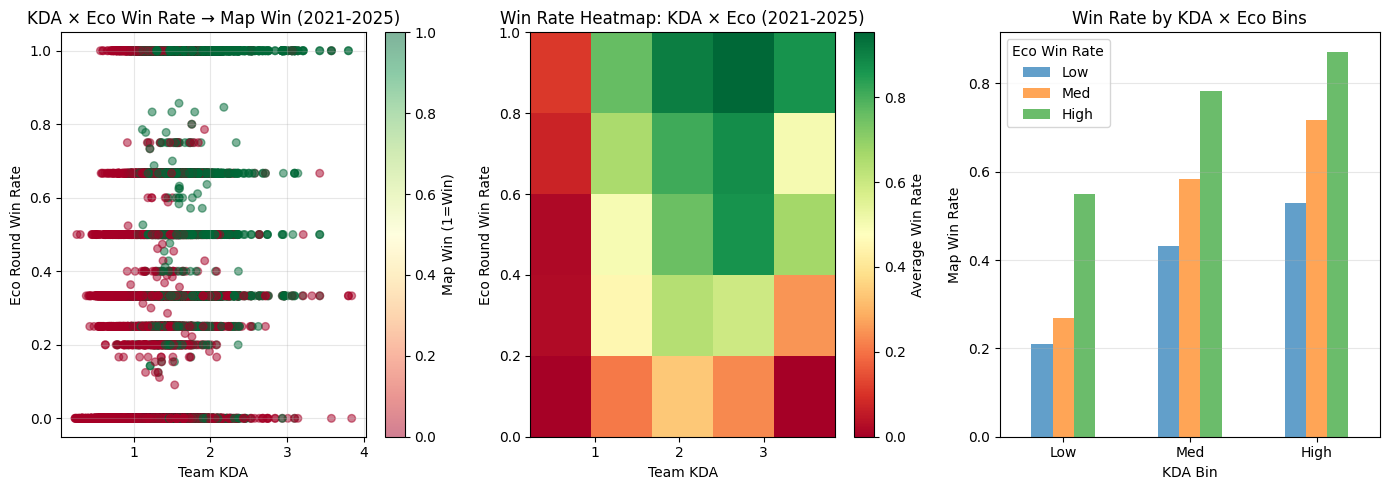

=== BIVARIATE: KDA × Eco Win Rate Bins -> Win Rate (2021-2025) ===
eco_bin       Low       Med      High
kda_bin                              
Low      0.209689  0.268556  0.549841
Med      0.432336  0.583226  0.782936
High     0.529713  0.717295  0.872191

Sample sizes:
eco_bin   Low  Med  High
kda_bin                 
Low      9681  741  2508
Med      8158  775  3985
High     7034  902  4984


In [128]:
# ==========BIVARIATE: KDA × ECO ROUND WIN RATE (2021-2025)==========
# Combining combat performance with economy management

import matplotlib.pyplot as plt
import numpy as np

# Merge team KDA with eco data at match level
# First, get team KDA per tournament (from earlier analysis)
team_kda_data = team_metrics[['Tournament', 'Teams', 'kda']].rename(columns={'Teams': 'team'})

# Merge with eco match data
eco_kda = eco_match.merge(
    team_kda_data,
    on=['Tournament', 'team'],
    how='inner'
)

# Merge with match results to get win outcome
eco_kda = eco_kda.merge(
    all_matches[['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team', 'win']],
    on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
    how='inner'
)

# --- PLOTS: Bivariate visualization ---
plt.figure(figsize=(14, 5))

# Plot 1: Scatter plot colored by win
plt.subplot(1, 3, 1)
scatter = plt.scatter(
    eco_kda['kda'],
    eco_kda['eco_round_win_rate'],
    c=eco_kda['win'],
    cmap='RdYlGn',
    alpha=0.5,
    s=30
)
plt.colorbar(scatter, label='Map Win (1=Win)')
plt.xlabel('Team KDA')
plt.ylabel('Eco Round Win Rate')
plt.title('KDA × Eco Win Rate → Map Win (2021-2025)')
plt.grid(True, alpha=0.3)

# Plot 2: 2D heatmap
plt.subplot(1, 3, 2)
kda_bins = np.linspace(eco_kda['kda'].min(), eco_kda['kda'].max(), 6)
eco_bins = np.linspace(eco_kda['eco_round_win_rate'].min(), 
                      eco_kda['eco_round_win_rate'].max(), 6)

hist, xedges, yedges = np.histogram2d(
    eco_kda['kda'], 
    eco_kda['eco_round_win_rate'], 
    bins=[kda_bins, eco_bins]
)
win_sum, _, _ = np.histogram2d(
    eco_kda['kda'], 
    eco_kda['eco_round_win_rate'], 
    bins=[kda_bins, eco_bins],
    weights=eco_kda['win']
)
win_rate_2d = np.divide(win_sum, hist, out=np.zeros_like(win_sum), where=hist!=0)

im = plt.imshow(win_rate_2d.T, origin='lower', aspect='auto', cmap='RdYlGn', 
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(im, label='Average Win Rate')
plt.xlabel('Team KDA')
plt.ylabel('Eco Round Win Rate')
plt.title('Win Rate Heatmap: KDA × Eco (2021-2025)')

# Plot 3: Grouped bar chart
plt.subplot(1, 3, 3)
eco_kda['kda_bin'] = pd.qcut(eco_kda['kda'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])
eco_kda['eco_bin'] = pd.qcut(eco_kda['eco_round_win_rate'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])

grouped_kda_eco = eco_kda.groupby(['kda_bin', 'eco_bin'], observed=True)['win'].mean().reset_index()
pivot_kda_eco = grouped_kda_eco.pivot(index='kda_bin', columns='eco_bin', values='win')

pivot_kda_eco.plot(kind='bar', ax=plt.gca(), alpha=0.7)
plt.xlabel('KDA Bin')
plt.ylabel('Map Win Rate')
plt.title('Win Rate by KDA × Eco Bins')
plt.legend(title='Eco Win Rate')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- BINS: 2D bin analysis ---
bivariate_kda_eco = eco_kda.groupby(['kda_bin', 'eco_bin'], observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("=== BIVARIATE: KDA × Eco Win Rate Bins -> Win Rate (2021-2025) ===")
print(bivariate_kda_eco.pivot(index='kda_bin', columns='eco_bin', values='avg_win_rate'))
print("\nSample sizes:")
print(bivariate_kda_eco.pivot(index='kda_bin', columns='eco_bin', values='count'))


In [145]:
# ==========GROUPED EDA: MAP × PISTOL WINS (2021-2025)==========
# Grouped analysis: How does pistol performance vary by map?

import matplotlib.pyplot as plt

# Use pistol_merged which already has map and pistol wins
map_pistol = pistol_merged.groupby(['Map', 'pistol_wins_bin'], observed=True).agg(
    map_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

# --- PLOTS: Grouped visualization ---
plt.figure(figsize=(14, 6))

# # Plot 1: Grouped bar chart by map
# pivot_map_pistol = map_pistol.pivot(index='Map', columns='pistol_wins_bin', values='map_win_rate')
# pivot_map_pistol.plot(kind='bar', ax=plt.gca(), alpha=0.7, width=0.8)
# plt.xlabel('Map')
# plt.ylabel('Map Win Rate')
# plt.title('Map Win Rate by Pistol Wins × Map (2021-2025)')
# plt.legend(title='Pistol Wins', labels=['0', '1', '2'])
# plt.xticks(rotation=45, ha='right')
# plt.grid(True, alpha=0.3, axis='y')
# plt.tight_layout()
# plt.show()

# # Plot 2: Heatmap
# plt.figure(figsize=(10, 6))
# im = plt.imshow(pivot_map_pistol.T, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
# plt.colorbar(im, label='Map Win Rate')
# plt.xlabel('Map')
# plt.ylabel('Pistol Wins')
# plt.title('Win Rate Heatmap: Map × Pistol Wins (2021-2025)')
# plt.yticks([0, 1, 2], ['0', '1', '2'])
# plt.xticks(range(len(pivot_map_pistol.index)), pivot_map_pistol.index, rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

print("=== GROUPED: Map × Pistol Wins -> Win Rate (2021-2025) ===")
print(pivot_map_pistol)
print("\nSample sizes:")
pivot_count = map_pistol.pivot(index='Map', columns='pistol_wins_bin', values='count')
print(pivot_count)


=== GROUPED: Map × Pistol Wins -> Win Rate (2021-2025) ===
pistol_wins_bin         0         1         2
Map                                          
Abyss            0.313433  0.500000  0.837838
Ascent           0.386883  0.500123  0.768140
Bind             0.397487  0.500000  0.760698
Breeze           0.267292  0.500000  0.749054
Corrode          0.452830  0.500000  0.592593
Fracture         0.284188  0.500000  0.751256
Haven            0.378003  0.500000  0.780948
Icebox           0.361226  0.500000  0.743917
Lotus            0.371560  0.500000  0.752252
Pearl            0.359155  0.500000  0.738095
Split            0.379704  0.499596  0.779088
Sunset           0.386667  0.500000  0.768421

Sample sizes:
pistol_wins_bin     0     1     2
Map                              
Abyss              67    58    37
Ascent           5733  4063  2398
Bind             4536  3146  1776
Breeze            853  1506   793
Corrode            53    66    27
Fracture          468   706   398
Haven     

<Figure size 1400x600 with 0 Axes>

In [146]:
# ==========GROUPED EDA: YEAR × KEY METRICS (2021-2025)==========
# Grouped analysis: How have key metrics changed over years?

import matplotlib.pyplot as plt

# Aggregate key metrics by year
yearly_metrics = all_matches.groupby('Year').agg(
    total_matches=('win', 'count'),
    avg_win_rate=('win', 'mean')
).reset_index()

# Merge with pistol data
yearly_pistol = pistol_merged.groupby(['Year', 'pistol_wins_bin'], observed=True).agg(
    map_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

# Merge with eco data
yearly_eco = eco_match.merge(
    all_matches[['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team', 'Year', 'win']],
    on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
    how='inner'
)
yearly_eco_agg = yearly_eco.groupby('Year').agg(
    avg_eco_win_rate=('eco_round_win_rate', 'mean'),
    avg_loadout=('avg_loadout', 'mean')
).reset_index()

# --- PLOTS: Yearly trends ---
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# # Plot 1: Total matches per year
# axes[0, 0].bar(yearly_metrics['Year'], yearly_metrics['total_matches'], alpha=0.7, color='steelblue')
# axes[0, 0].set_xlabel('Year')
# axes[0, 0].set_ylabel('Total Matches')
# axes[0, 0].set_title('Total Matches by Year (2021-2025)')
# axes[0, 0].grid(True, alpha=0.3, axis='y')

# # Plot 2: Pistol win impact by year
# pivot_yearly_pistol = yearly_pistol.pivot(index='Year', columns='pistol_wins_bin', values='map_win_rate')
# pivot_yearly_pistol.plot(kind='line', ax=axes[0, 1], marker='o', linewidth=2)
# axes[0, 1].set_xlabel('Year')
# axes[0, 1].set_ylabel('Map Win Rate')
# axes[0, 1].set_title('Pistol Impact on Win Rate by Year')
# axes[0, 1].legend(title='Pistol Wins', labels=['0', '1', '2'])
# axes[0, 1].grid(True, alpha=0.3)

# # Plot 3: Eco round win rate by year
# axes[1, 0].plot(yearly_eco_agg['Year'], yearly_eco_agg['avg_eco_win_rate'], 
#                 marker='o', linewidth=2, color='green', label='Eco Win Rate')
# axes[1, 0].set_xlabel('Year')
# axes[1, 0].set_ylabel('Average Eco Round Win Rate')
# axes[1, 0].set_title('Eco Round Performance by Year')
# axes[1, 0].grid(True, alpha=0.3)
# axes[1, 0].legend()

# # Plot 4: Average loadout value by year
# ax2 = axes[1, 0].twinx()
# ax2.plot(yearly_eco_agg['Year'], yearly_eco_agg['avg_loadout'], 
#          marker='s', linewidth=2, color='orange', linestyle='--', label='Avg Loadout')
# ax2.set_ylabel('Average Loadout Value', color='orange')
# ax2.tick_params(axis='y', labelcolor='orange')
# axes[1, 0].legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Plot 4: KDA trends by year (if available)
# # Get Year from player_stats_all since team_metrics doesn't have Year column
# # Aggregate KDA by Year directly from player stats
# yearly_kda = player_stats_all.groupby('Year')['kda'].mean().reset_index()
# axes[1, 1].plot(yearly_kda['Year'], yearly_kda['kda'], marker='o', linewidth=2, color='purple')
# axes[1, 1].set_xlabel('Year')
# axes[1, 1].set_ylabel('Average Team KDA')
# axes[1, 1].set_title('Average Team KDA by Year')
# axes[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print("=== GROUPED: Yearly Trends Summary (2021-2025) ===")
# print("\nTotal Matches by Year:")
# print(yearly_metrics)
# print("\nPistol Impact by Year:")
# print(pivot_yearly_pistol)
# print("\nEco Performance by Year:")
# print(yearly_eco_agg)


In [148]:
# ==========GROUPED EDA: PISTOL WINS × FK DIFFERENTIAL (2021-2025)==========
# Combining early game performance (pistol) with first engagement performance (FK diff)
# This explores if teams that win pistols AND have good FK differential perform better

import matplotlib.pyplot as plt
import numpy as np

# Get FK diff data at match level - need to merge with match data
# First, get team FK diff per tournament (from earlier analysis)
team_fk_match = team_fk_merged[['Tournament', 'Teams', 'fk_diff']].rename(columns={'Teams': 'team'})

# Merge FK diff with pistol data at match level
# pistol_merged already has 'win' and 'Year' from all_matches, so we just need to add FK diff
# Merge with FK diff data (at tournament level)
pistol_fk = pistol_merged.merge(
    team_fk_match,
    on=['Tournament', 'team'],
    how='inner'
)

# Ensure 'win' column exists - if merge dropped it somehow, add it back
if 'win' not in pistol_fk.columns:
    pistol_fk = pistol_fk.merge(
        all_matches[['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team', 'win']],
        on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
        how='inner'
    )

# --- PLOTS: Bivariate visualization ---
# plt.figure(figsize=(16, 5))

# Plot 1: Scatter plot colored by win
# plt.subplot(1, 4, 1)
# scatter = plt.scatter(
#     pistol_fk['pistol_wins'],
#     pistol_fk['fk_diff'],
#     c=pistol_fk['win'],
#     cmap='RdYlGn',
#     alpha=0.4,
#     s=20
# )
# plt.colorbar(scatter, label='Map Win (1=Win)')
# plt.xlabel('Pistol Wins')
# plt.ylabel('Team FK Differential')
# plt.title('Pistol Wins × FK Diff → Map Win (2021-2025)')
# plt.xticks([0, 1, 2])
# plt.grid(True, alpha=0.3)

# # Plot 2: 2D heatmap
# plt.subplot(1, 4, 2)
pistol_bins = [0, 0.5, 1.5, 2.5]
fk_bins = np.linspace(pistol_fk['fk_diff'].min(), pistol_fk['fk_diff'].max(), 6)

hist, xedges, yedges = np.histogram2d(
    pistol_fk['pistol_wins'], 
    pistol_fk['fk_diff'], 
    bins=[pistol_bins, fk_bins]
)
win_sum, _, _ = np.histogram2d(
    pistol_fk['pistol_wins'], 
    pistol_fk['fk_diff'], 
    bins=[pistol_bins, fk_bins],
    weights=pistol_fk['win']
)
win_rate_2d = np.divide(win_sum, hist, out=np.zeros_like(win_sum), where=hist!=0)

# im = plt.imshow(win_rate_2d.T, origin='lower', aspect='auto', cmap='RdYlGn', vmin=0, vmax=1,
#                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
# plt.colorbar(im, label='Average Win Rate')
# plt.xlabel('Pistol Wins')
# plt.ylabel('FK Differential')
# plt.title('Win Rate Heatmap: Pistol × FK Diff')
# plt.xticks([0, 1, 2])

# # Plot 3: Grouped bar chart
# plt.subplot(1, 4, 3)
pistol_fk['pistol_bin'] = pd.cut(pistol_fk['pistol_wins'], bins=[-0.5, 0.5, 1.5, 2.5], labels=['0', '1', '2'])
pistol_fk['fk_bin'] = pd.qcut(pistol_fk['fk_diff'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])

grouped_pf = pistol_fk.groupby(['pistol_bin', 'fk_bin'], observed=True)['win'].mean().reset_index()
pivot_pf = grouped_pf.pivot(index='pistol_bin', columns='fk_bin', values='win')

# pivot_pf.plot(kind='bar', ax=plt.gca(), alpha=0.7, width=0.8)
# plt.xlabel('Pistol Wins')
# plt.ylabel('Map Win Rate')
# plt.title('Win Rate by Pistol × FK Diff Bins')
# plt.legend(title='FK Diff')
# plt.xticks(rotation=0)
# plt.grid(True, alpha=0.3, axis='y')

# Plot 4: Interaction lines
# plt.subplot(1, 4, 4)
for pistol_val in [0, 1, 2]:
    subset = pistol_fk[pistol_fk['pistol_wins'] == pistol_val]
    subset['fk_bin_num'] = pd.qcut(subset['fk_diff'], 3, duplicates='drop')
    line_data = subset.groupby('fk_bin_num', observed=True)['win'].mean()
#     plt.plot(range(len(line_data)), line_data, marker='o', 
#              label=f'{pistol_val} Pistol Wins', linewidth=2, markersize=8)

# plt.xlabel('FK Differential Quartile')
# plt.ylabel('Map Win Rate')
# plt.title('Interaction: Pistol × FK Diff (2021-2025)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xticks(range(3), ['Low', 'Med', 'High'])

# plt.tight_layout()
# plt.show()

# --- BINS: 2D bin analysis ---
bivariate_pistol_fk = pistol_fk.groupby(['pistol_bin', 'fk_bin'], observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("=== GROUPED: Pistol Wins × FK Differential Bins -> Win Rate (2021-2025) ===")
print(bivariate_pistol_fk.pivot(index='pistol_bin', columns='fk_bin', values='avg_win_rate'))
print("\nSample sizes:")
print(bivariate_pistol_fk.pivot(index='pistol_bin', columns='fk_bin', values='count'))

# Calculate improvement over univariate
print("\n=== ANALYSIS: Interaction Strength ===")
pistol_only = pistol_fk.groupby('pistol_bin', observed=True)['win'].mean()
fk_only = pistol_fk.groupby('fk_bin', observed=True)['win'].mean()
print(f"Pistol-only effect range: {pistol_only.max() - pistol_only.min():.3f}")
print(f"FK-only effect range: {fk_only.max() - fk_only.min():.3f}")
print(f"Combined effect range: {bivariate_pistol_fk['avg_win_rate'].max() - bivariate_pistol_fk['avg_win_rate'].min():.3f}")


=== GROUPED: Pistol Wins × FK Differential Bins -> Win Rate (2021-2025) ===
fk_bin           Low       Med      High
pistol_bin                              
0           0.235265  0.390496  0.549335
1           0.384375  0.479730  0.634089
2           0.643123  0.748726  0.853415

Sample sizes:
fk_bin       Low   Med  High
pistol_bin                  
0           8127  8607  6091
1           6733  5920  6794
2           2959  3140  4598

=== ANALYSIS: Interaction Strength ===
Pistol-only effect range: 0.387
FK-only effect range: 0.303
Combined effect range: 0.618


C:\Users\noble\AppData\Local\Temp\ipykernel_6176\1709256019.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['fk_bin_num'] = pd.qcut(subset['fk_diff'], 3, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\1709256019.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['fk_bin_num'] = pd.qcut(subset['fk_diff'], 3, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\1709256019.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\noble\AppData\Local\Temp\ipykernel_6176\1744510889.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['pref_bin_num'] = pd.qcut(subset['pref_score'], 3, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\1744510889.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['pref_bin_num'] = pd.qcut(subset['pref_score'], 3, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\1744510889.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy

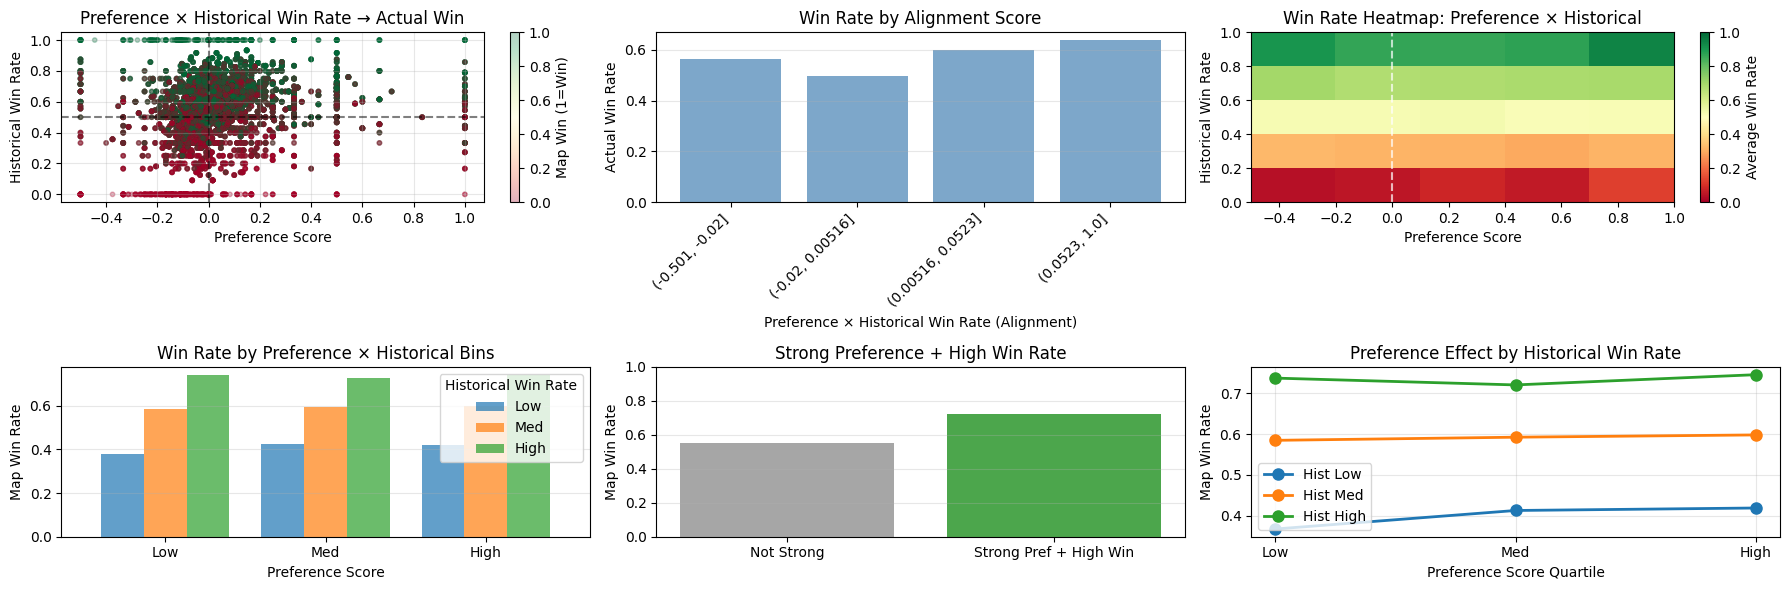

=== GROUPED: Map Preference × Historical Win Rate Bins -> Win Rate (2021-2025) ===
hist_bin       Low       Med      High
pref_bin                              
Low       0.376737  0.583905  0.738180
Med       0.422446  0.593196  0.724744
High      0.417778  0.597814  0.740042

Sample sizes:
hist_bin   Low   Med  High
pref_bin                  
Low       4247  2771  1967
Med       2379  3498  3128
High      2475  2653  3816

=== ANALYSIS: Map Preference Strengthening ===
Preference-only effect range: 0.089
Historical-only effect range: 0.334
Combined effect range: 0.363

Alignment Score Correlation with Win: 0.052
Strong Pref + High Win Rate Win Rate: 0.721
Other cases Win Rate: 0.551


In [134]:
# ==========GROUPED EDA: MAP PREFERENCE × HISTORICAL MAP WIN RATE (2021-2025)==========
# Strengthening map preference predictor by combining with historical performance
# Hypothesis: Teams that prefer maps they're historically good at should win more

import matplotlib.pyplot as plt
import numpy as np

# team_pref already has preference score and win_rate (historical)
# But we need to merge with actual match outcomes to see if the combination is stronger
# Let's create a match-level analysis

# Get historical win rate at match level (from matches_hist)
# Merge team_pref with match data
pref_hist = all_matches.merge(
    team_pref[['Team', 'Map', 'pref_score', 'pick_fraction', 'ban_fraction']],
    left_on=['team', 'Map'],
    right_on=['Team', 'Map'],
    how='inner'
)

# Merge with historical win rate
pref_hist = pref_hist.merge(
    matches_hist[['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team', 'historical_win_rate']],
    on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
    how='inner'
)

# Create interaction features
# 1. Alignment: Does team prefer maps they're good at?
pref_hist['pref_hist_alignment'] = pref_hist['pref_score'] * pref_hist['historical_win_rate']
# 2. Strong preference + high win rate
pref_hist['strong_pref_high_win'] = ((pref_hist['pref_score'] > 0.1) & (pref_hist['historical_win_rate'] > 0.6)).astype(int)
# 3. Weak preference + low win rate (should avoid)
pref_hist['weak_pref_low_win'] = ((pref_hist['pref_score'] < -0.1) & (pref_hist['historical_win_rate'] < 0.4)).astype(int)

# --- PLOTS: Comprehensive visualization ---
plt.figure(figsize=(18, 6))

# Plot 1: Scatter - preference vs historical win rate, colored by actual win
plt.subplot(2, 3, 1)
scatter = plt.scatter(
    pref_hist['pref_score'],
    pref_hist['historical_win_rate'],
    c=pref_hist['win'],
    cmap='RdYlGn',
    alpha=0.3,
    s=10
)
plt.colorbar(scatter, label='Map Win (1=Win)')
plt.xlabel('Preference Score')
plt.ylabel('Historical Win Rate')
plt.title('Preference × Historical Win Rate → Actual Win')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot 2: Alignment score vs actual win
plt.subplot(2, 3, 2)
pref_hist['alignment_bin'] = pd.qcut(pref_hist['pref_hist_alignment'], 4, duplicates='drop')
alignment_summary = pref_hist.groupby('alignment_bin', observed=True).agg(
    win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

bin_labels = [str(interval) for interval in alignment_summary['alignment_bin']]
plt.bar(range(len(alignment_summary)), alignment_summary['win_rate'], alpha=0.7, color='steelblue')
plt.xlabel('Preference × Historical Win Rate (Alignment)')
plt.ylabel('Actual Win Rate')
plt.title('Win Rate by Alignment Score')
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Plot 3: 2D heatmap
plt.subplot(2, 3, 3)
pref_bins = np.linspace(pref_hist['pref_score'].min(), pref_hist['pref_score'].max(), 6)
hist_bins = np.linspace(0, 1, 6)

hist, xedges, yedges = np.histogram2d(
    pref_hist['pref_score'], 
    pref_hist['historical_win_rate'], 
    bins=[pref_bins, hist_bins]
)
win_sum, _, _ = np.histogram2d(
    pref_hist['pref_score'], 
    pref_hist['historical_win_rate'], 
    bins=[pref_bins, hist_bins],
    weights=pref_hist['win']
)
win_rate_2d = np.divide(win_sum, hist, out=np.zeros_like(win_sum), where=hist!=0)

im = plt.imshow(win_rate_2d.T, origin='lower', aspect='auto', cmap='RdYlGn', vmin=0, vmax=1,
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(im, label='Average Win Rate')
plt.xlabel('Preference Score')
plt.ylabel('Historical Win Rate')
plt.title('Win Rate Heatmap: Preference × Historical')
plt.axvline(x=0, color='white', linestyle='--', alpha=0.7)

# Plot 4: Grouped by preference and historical bins
plt.subplot(2, 3, 4)
pref_hist['pref_bin'] = pd.qcut(pref_hist['pref_score'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])
pref_hist['hist_bin'] = pd.qcut(pref_hist['historical_win_rate'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])

grouped_ph = pref_hist.groupby(['pref_bin', 'hist_bin'], observed=True)['win'].mean().reset_index()
pivot_ph = grouped_ph.pivot(index='pref_bin', columns='hist_bin', values='win')

pivot_ph.plot(kind='bar', ax=plt.gca(), alpha=0.7, width=0.8)
plt.xlabel('Preference Score')
plt.ylabel('Map Win Rate')
plt.title('Win Rate by Preference × Historical Bins')
plt.legend(title='Historical Win Rate')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

# Plot 5: Strong preference + high win rate analysis
plt.subplot(2, 3, 5)
strong_analysis = pref_hist.groupby('strong_pref_high_win', observed=True).agg(
    win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()
plt.bar(['Not Strong', 'Strong Pref + High Win'], strong_analysis['win_rate'], 
        alpha=0.7, color=['gray', 'green'])
plt.ylabel('Map Win Rate')
plt.title('Strong Preference + High Win Rate')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Plot 6: Interaction lines - preference effect at different historical win rates
plt.subplot(2, 3, 6)
for hist_label in ['Low', 'Med', 'High']:
    subset = pref_hist[pref_hist['hist_bin'] == hist_label]
    subset['pref_bin_num'] = pd.qcut(subset['pref_score'], 3, duplicates='drop')
    line_data = subset.groupby('pref_bin_num', observed=True)['win'].mean()
    plt.plot(range(len(line_data)), line_data, marker='o', 
             label=f'Hist {hist_label}', linewidth=2, markersize=8)

plt.xlabel('Preference Score Quartile')
plt.ylabel('Map Win Rate')
plt.title('Preference Effect by Historical Win Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(3), ['Low', 'Med', 'High'])

plt.tight_layout()
plt.show()

# --- BINS: Detailed analysis ---
bivariate_pref_hist = pref_hist.groupby(['pref_bin', 'hist_bin'], observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("=== GROUPED: Map Preference × Historical Win Rate Bins -> Win Rate (2021-2025) ===")
print(bivariate_pref_hist.pivot(index='pref_bin', columns='hist_bin', values='avg_win_rate'))
print("\nSample sizes:")
print(bivariate_pref_hist.pivot(index='pref_bin', columns='hist_bin', values='count'))

# Calculate improvement metrics
print("\n=== ANALYSIS: Map Preference Strengthening ===")
pref_only = pref_hist.groupby('pref_bin', observed=True)['win'].mean()
hist_only = pref_hist.groupby('hist_bin', observed=True)['win'].mean()
print(f"Preference-only effect range: {pref_only.max() - pref_only.min():.3f}")
print(f"Historical-only effect range: {hist_only.max() - hist_only.min():.3f}")
print(f"Combined effect range: {bivariate_pref_hist['avg_win_rate'].max() - bivariate_pref_hist['avg_win_rate'].min():.3f}")

# Alignment analysis
print(f"\nAlignment Score Correlation with Win: {pref_hist['pref_hist_alignment'].corr(pref_hist['win']):.3f}")
print(f"Strong Pref + High Win Rate Win Rate: {pref_hist[pref_hist['strong_pref_high_win']==1]['win'].mean():.3f}")
print(f"Other cases Win Rate: {pref_hist[pref_hist['strong_pref_high_win']==0]['win'].mean():.3f}")


In [149]:
# ==========GROUPED EDA: ECO ROUND PERFORMANCE × KDA (2021-2025)==========
# Combining economy management with combat performance
# This explores if teams that manage economy well AND have high KDA perform better

import matplotlib.pyplot as plt
import numpy as np

# We already have eco_kda from earlier, but let's enhance it
# Get team KDA per tournament (from earlier analysis)
team_kda_data = team_metrics[['Tournament', 'Teams', 'kda']].rename(columns={'Teams': 'team'})

# Merge with eco match data
eco_kda_enhanced = eco_match.merge(
    team_kda_data,
    on=['Tournament', 'team'],
    how='inner'
)

# Merge with match results to get win outcome
eco_kda_enhanced = eco_kda_enhanced.merge(
    all_matches[['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team', 'win']],
    on=['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'team'],
    how='inner'
)

# Create interaction features
# 1. Combined score: high KDA + high eco win rate
eco_kda_enhanced['kda_eco_score'] = (eco_kda_enhanced['kda'] / eco_kda_enhanced['kda'].max()) + \
                                     (eco_kda_enhanced['eco_round_win_rate'] / eco_kda_enhanced['eco_round_win_rate'].max())
# 2. Strong in both
eco_kda_enhanced['strong_both'] = ((eco_kda_enhanced['kda'] > eco_kda_enhanced['kda'].quantile(0.75)) & 
                                   (eco_kda_enhanced['eco_round_win_rate'] > eco_kda_enhanced['eco_round_win_rate'].quantile(0.75))).astype(int)
# 3. Weak in both
eco_kda_enhanced['weak_both'] = ((eco_kda_enhanced['kda'] < eco_kda_enhanced['kda'].quantile(0.25)) & 
                                (eco_kda_enhanced['eco_round_win_rate'] < eco_kda_enhanced['eco_round_win_rate'].quantile(0.25))).astype(int)

# --- PLOTS: Comprehensive visualization ---
# plt.figure(figsize=(18, 6))

# # Plot 1: Scatter - KDA vs eco win rate, colored by actual win
# plt.subplot(2, 3, 1)
# scatter = plt.scatter(
#     eco_kda_enhanced['kda'],
#     eco_kda_enhanced['eco_round_win_rate'],
#     c=eco_kda_enhanced['win'],
#     cmap='RdYlGn',
#     alpha=0.4,
#     s=20
# )
# plt.colorbar(scatter, label='Map Win (1=Win)')
# plt.xlabel('Team KDA')
# plt.ylabel('Eco Round Win Rate')
# plt.title('KDA × Eco Win Rate → Map Win (2021-2025)')
# plt.grid(True, alpha=0.3)

# # Plot 2: 2D heatmap
# plt.subplot(2, 3, 2)
kda_bins = np.linspace(eco_kda_enhanced['kda'].min(), eco_kda_enhanced['kda'].max(), 6)
eco_bins = np.linspace(eco_kda_enhanced['eco_round_win_rate'].min(), 
                      eco_kda_enhanced['eco_round_win_rate'].max(), 6)

hist, xedges, yedges = np.histogram2d(
    eco_kda_enhanced['kda'], 
    eco_kda_enhanced['eco_round_win_rate'], 
    bins=[kda_bins, eco_bins]
)
win_sum, _, _ = np.histogram2d(
    eco_kda_enhanced['kda'], 
    eco_kda_enhanced['eco_round_win_rate'], 
    bins=[kda_bins, eco_bins],
    weights=eco_kda_enhanced['win']
)
win_rate_2d = np.divide(win_sum, hist, out=np.zeros_like(win_sum), where=hist!=0)

# im = plt.imshow(win_rate_2d.T, origin='lower', aspect='auto', cmap='RdYlGn', vmin=0, vmax=1,
#                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
# plt.colorbar(im, label='Average Win Rate')
# plt.xlabel('Team KDA')
# plt.ylabel('Eco Round Win Rate')
# plt.title('Win Rate Heatmap: KDA × Eco')

# # Plot 3: Grouped bar chart
# plt.subplot(2, 3, 3)
eco_kda_enhanced['kda_bin'] = pd.qcut(eco_kda_enhanced['kda'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])
eco_kda_enhanced['eco_bin'] = pd.qcut(eco_kda_enhanced['eco_round_win_rate'], 3, duplicates='drop', labels=['Low', 'Med', 'High'])

grouped_ek = eco_kda_enhanced.groupby(['kda_bin', 'eco_bin'], observed=True)['win'].mean().reset_index()
pivot_ek = grouped_ek.pivot(index='kda_bin', columns='eco_bin', values='win')

# pivot_ek.plot(kind='bar', ax=plt.gca(), alpha=0.7, width=0.8)
# plt.xlabel('KDA Bin')
# plt.ylabel('Map Win Rate')
# plt.title('Win Rate by KDA × Eco Bins')
# plt.legend(title='Eco Win Rate')
# plt.xticks(rotation=0)
# plt.grid(True, alpha=0.3, axis='y')

# # Plot 4: Combined score analysis
# plt.subplot(2, 3, 4)
eco_kda_enhanced['combined_bin'] = pd.qcut(eco_kda_enhanced['kda_eco_score'], 4, duplicates='drop')
combined_summary = eco_kda_enhanced.groupby('combined_bin', observed=True).agg(
    win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

# bin_labels = [str(interval) for interval in combined_summary['combined_bin']]
# plt.bar(range(len(combined_summary)), combined_summary['win_rate'], alpha=0.7, color='steelblue')
# plt.xlabel('Combined KDA + Eco Score')
# plt.ylabel('Map Win Rate')
# plt.title('Win Rate by Combined Score')
# plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, ha='right')
# plt.grid(True, alpha=0.3, axis='y')

# # Plot 5: Strong in both vs others
# plt.subplot(2, 3, 5)
strong_analysis = eco_kda_enhanced.groupby('strong_both', observed=True).agg(
    win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()
# plt.bar(['Not Strong', 'Strong in Both'], strong_analysis['win_rate'], 
#         alpha=0.7, color=['gray', 'green'])
# plt.ylabel('Map Win Rate')
# plt.title('Strong KDA + Strong Eco Performance')
# plt.ylim([0, 1])
# plt.grid(True, alpha=0.3, axis='y')

# # Plot 6: Interaction lines - KDA effect at different eco levels
# plt.subplot(2, 3, 6)
for eco_label in ['Low', 'Med', 'High']:
    subset = eco_kda_enhanced[eco_kda_enhanced['eco_bin'] == eco_label]
    subset['kda_bin_num'] = pd.qcut(subset['kda'], 3, duplicates='drop')
    line_data = subset.groupby('kda_bin_num', observed=True)['win'].mean()
#     plt.plot(range(len(line_data)), line_data, marker='o', 
#              label=f'Eco {eco_label}', linewidth=2, markersize=8)

# plt.xlabel('KDA Quartile')
# plt.ylabel('Map Win Rate')
# plt.title('KDA Effect by Eco Performance Level')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xticks(range(3), ['Low', 'Med', 'High'])

# plt.tight_layout()
# plt.show()

# --- BINS: Detailed analysis ---
bivariate_eco_kda = eco_kda_enhanced.groupby(['kda_bin', 'eco_bin'], observed=True).agg(
    avg_win_rate=('win', 'mean'),
    count=('win', 'count')
).reset_index()

print("=== GROUPED: Eco Round Performance × KDA Bins -> Win Rate (2021-2025) ===")
print(bivariate_eco_kda.pivot(index='kda_bin', columns='eco_bin', values='avg_win_rate'))
print("\nSample sizes:")
print(bivariate_eco_kda.pivot(index='kda_bin', columns='eco_bin', values='count'))

# Calculate improvement metrics
print("\n=== ANALYSIS: Interaction Strength ===")
kda_only = eco_kda_enhanced.groupby('kda_bin', observed=True)['win'].mean()
eco_only = eco_kda_enhanced.groupby('eco_bin', observed=True)['win'].mean()
print(f"KDA-only effect range: {kda_only.max() - kda_only.min():.3f}")
print(f"Eco-only effect range: {eco_only.max() - eco_only.min():.3f}")
print(f"Combined effect range: {bivariate_eco_kda['avg_win_rate'].max() - bivariate_eco_kda['avg_win_rate'].min():.3f}")

# Combined score analysis
print(f"\nCombined Score Correlation with Win: {eco_kda_enhanced['kda_eco_score'].corr(eco_kda_enhanced['win']):.3f}")
print(f"Strong in Both Win Rate: {eco_kda_enhanced[eco_kda_enhanced['strong_both']==1]['win'].mean():.3f}")
print(f"Other cases Win Rate: {eco_kda_enhanced[eco_kda_enhanced['strong_both']==0]['win'].mean():.3f}")
print(f"Weak in Both Win Rate: {eco_kda_enhanced[eco_kda_enhanced['weak_both']==1]['win'].mean():.3f}")


=== GROUPED: Eco Round Performance × KDA Bins -> Win Rate (2021-2025) ===
eco_bin       Low       Med      High
kda_bin                              
Low      0.209689  0.268556  0.549841
Med      0.432336  0.583226  0.782936
High     0.529713  0.717295  0.872191

Sample sizes:
eco_bin   Low  Med  High
kda_bin                 
Low      9681  741  2508
Med      8158  775  3985
High     7034  902  4984

=== ANALYSIS: Interaction Strength ===
KDA-only effect range: 0.396
Eco-only effect range: 0.398
Combined effect range: 0.663

Combined Score Correlation with Win: 0.460
Strong in Both Win Rate: 0.903
Other cases Win Rate: 0.466
Weak in Both Win Rate: 0.081


C:\Users\noble\AppData\Local\Temp\ipykernel_6176\3503935704.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['kda_bin_num'] = pd.qcut(subset['kda'], 3, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\3503935704.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['kda_bin_num'] = pd.qcut(subset['kda'], 3, duplicates='drop')
C:\Users\noble\AppData\Local\Temp\ipykernel_6176\3503935704.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

## Step 2: Observe and Take Notes


**What was already mentioned above:**
- We can see that KDA and ACS are redundant/very similar and in practice as well. We know from understanding of the game that they come from the same values, kills (basically). From my observation, the KDA plot looks ever so slightly stronger in correlation so for now, I drop ACS
- Headshot % was really bad univariate so I decided that we don't need to see it anymore, it isn't really showing of anything. There was an idea that I could combine that headshot % value with something more meaningful like KDA to improve the factor but I don't think it is that worth it and may just devalue KDA instead
- Map picks and bans are not decisive so it needs to be paired with another feature
- Opponent map matchup is a strong predictor like if team A won against team B on map 1 >70% of the time, they are 90%+ likely to win BUT there is less data to create this relationship since teams play with multiple different teams and not always with the same few teams.
    - Consider how this might skew internationals to be harder to predict versus regionals (since regionals play each other more than cross regions)

**More notes:**
- KDA, pistol wins, and FK diffs are pretty good predictors behind opponent matchup being the best
- Lets put eco round and KDA on interactions after eco round has been aggregated. The bivariate shows that this helps a lot (poor KDA but high eco win only gives about 50% win rate while good KDA and high eco win gives 80% win rate)
- Historical map win rate is a pretty good predictor as well but is even more powerful with opponent matchup. Let's find a way to make them a strong predictor together especially since they are, at the core, basically the same.
- Higher loadout value in eco rounds gives higher round win rate which is pretty logically, don't really need more digging in that. Generally, being able to win those eco rounds is good to match winning
- If we want to use eco rounds, we needed to aggregate the stats. Since it is so round by round based and loadout value is related to how an eco round goes, we need to make it a map-level feature. Pistol rounds, for example, though also round based, is limited to two per map so it is already "map-level" rather than changes by round. Having to go eco is already usually a bad sign since you usually lose to have no money, so how that got there and what money you still have is important.

**Thoughts about interactions:**
1. Additive "Interactions" - Here this is straightforward stuff, KDA + pistol wins + FK diff ~ wins. Each item works alone and no interaction is needed
2. Synergistic Interactions - Both items matter but together, they show a deeper picture. This is what we call our eco round x KDA interaction where as the team is better in their KDA, the more the profit from winning their eco rounds.
3. Conditional Interactions - Certain variable only matters when a certain condition is met. This is our map preference. Map preference doesn't really matter unless a team is already good at that map. Preference reflects confidence *on top* of skill
4. Contextual "Interactions" - This depends on the opponent or environment, things like that. Like our opponent matchup is a very hard factor to work with because it isn't a performance trait, rather the trait of a situation.

### Conclusion
| Factor                             | Type / Role                      | Notes / Next Steps                                                                                                   |
| ---------------------------------- | -------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **KDA**                            | Strong additive                  | Keep as predictor; consider standardization or log transform (for linear/logistic models)                            |
| **FK diff**                        | Strong additive                  | Keep as predictor; may need shifted log (to handle negative values)                                                  |
| **Eco round**                      | Weak alone w/ aggregating | Aggregate per map/team; can include raw or binned (0–1 fraction). Consider including additive effect too if desired. |
| **Eco × KDA**                      | Interaction / synergy            | Captures that high KDA teams benefit more from eco wins; add as separate column.                                     |
| **Pistol round**                   | Strong additive                  | Keep as is; integer 0–2 no transformation needed.                                                   |
| **Historical map win rate (HMWR)** | Additive baseline                | Scale 0–1 or logit if using linear/logistic models; also used in conditional interaction with map preference.        |
| **Opponent map matchup (OMM)**     | Contextual / sparse              | Smooth/shrink (e.g., Bayesian prior) to stabilize; can also consider logit transform if linear/logistic.             |
| **Map preference × HMWR**          | Conditional interaction          | Captures “picking maps you are already strong at”; map preference alone is weak, only keep as interaction.           |


## Step 3: Pre-Model Data Modifications
Now we have to focus on aggregating, transforming, interactions, and shrinking/smoothing features. Be careful not to use the data that has already been altered and used for EDA, those are not the data we want to build off of.

### 3.1 Aggregating
At this point, I think we're only aggregating the eco rounds so that it can be compared on a map level rather than round by round. This is looked at through the average round win rate and average loadout value. I know, it flattens the relationship between loadout value and round win but loadout value is only most relevant when predicting the round win. Right now our aim is map level, map win.

In [9]:
# ==========AAGGREGATING ECO ROUNDS==========
eco = pd.read_csv("eco_rounds_2021_2025.csv")

# Drop any missing critical data
eco = eco.dropna(subset=['round_win','Loadout Value','Team','Map'])

# Make sure Loadout Value is numeric
eco['Loadout Value'] = pd.to_numeric(eco['Loadout Value'], errors='coerce')
eco = eco.dropna(subset=['Loadout Value'])

# Aggregate per team/map/match
agg_cols = ['Tournament','Stage','Match Type','Match Name','Map','Team','Year']

eco_agg = eco.groupby(agg_cols).agg(
    avg_eco_win_rate=('round_win','mean'),
    avg_loadout=('Loadout Value','mean'),
    eco_rounds_played=('round_win','count')
).reset_index()

# Preview the aggregated table
# print(eco_agg.head(10))

# Optional: check overall statistics
print(eco_agg.describe())


               Year  avg_eco_win_rate   avg_loadout  eco_rounds_played
count  39904.000000      39904.000000  39904.000000       39904.000000
mean    2021.749048          0.434703   3403.056939           2.989074
std        0.911888          0.353926    454.644214           0.881371
min     2021.000000          0.000000      0.000000           1.000000
25%     2021.000000          0.250000   3100.000000           2.000000
50%     2022.000000          0.333333   3450.000000           3.000000
75%     2022.000000          0.666667   3750.000000           3.000000
max     2025.000000          1.000000   4600.000000          24.000000


### 3.2 Basic Transformation
